In [7]:
import random
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tensorflow.keras import models
from tensorflow.keras import layers

BATCH_SIZE = 32
IMG_SIZE = 224

TRAIN_DIR = './data/pre/train_images/'
TEST_DIR = './data/pre/test_images/'
ROOT_DIR = './data/pre/'
MODELS_DIR = './TempModels/2'

TRAIN_DF = pd.read_csv('./data/pre/train.csv')
TEST_DF = pd.read_csv('./data/pre/test.csv')

CNTS = np.array([[1443, 362],
                 [295, 75],
                 [799, 200],
                 [154, 39],
                 [235, 60]])

In [8]:
def GetSingleClass(df,c,n):
    lx = (df['class'] == c) & (df['type'] == 0)
    res = list(df[lx]['filename'].to_numpy())
    if lx.sum() > n:
        return res[:n]
    m = n - lx.sum()
    lx = (df['class'] == c) & (df['type'] != 0)
    lst = list(df[lx].sort_values(by='type')['filename'].to_numpy())
    res += lst[:m]
    return res
    
def GetClassesElements(df,cv,nv):
    res = []
    for i in range(len(cv)):
        res += GetSingleClass(df,cv[i],nv[i])
    return res

def ModifyDataFrame(df,cv,nv):
    fv1 = GetClassesElements(df,cv[0],nv[0])
    fv2 = GetClassesElements(df,cv[1],nv[1])
    df = pd.DataFrame({'filename' : fv1 + fv2, 'class' : ['0']*len(fv1) + ['1']*len(fv2)})
    return df
        
def GetGenerator(df,rootdir,bs = 32):
    for i in range(100):
        df = df.sample(frac = 1).reset_index(drop=True)
    gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
    tr_gen = gen.flow_from_dataframe(df,target_size = (IMG_SIZE, IMG_SIZE),directory = rootdir,
                                     class_mode = 'binary', batch_size = bs) 
    return tr_gen

def SaveModel(model,name):
    path = os.path.join(MODELS_DIR,name)
    for suf in [''] + [str(i) for i in range(256)]:
        modified_path = path + suf
        if not os.path.exists(modified_path):
            os.makedirs(modified_path)
            path = modified_path
            break
    model.save(path)
    return path

def draw_evolution(history):
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    for hist in history:
        acc += hist.history['accuracy']
        val_acc += hist.history['val_accuracy']
        loss += hist.history['loss']
        val_loss += hist.history['val_loss']
    print('Test: Accuracy mean/std - {}/{}'.format(np.mean(np.array(val_acc)),np.std(np.array(val_acc))))
    print('Test: Loss mean/std - {}/{}'.format(np.mean(np.array(val_loss)),np.std(np.array(val_loss))))
    print('Train: Accuracy mean/std - {}/{}'.format(np.mean(np.array(acc)),np.std(np.array(acc))))
    print('Train: Loss mean/std - {}/{}'.format(np.mean(np.array(loss)),np.std(np.array(loss))))
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [34]:
train_batch_size = 64
train_set = [[2],[3,4]]
train_cnts = [[1400], [700,700]]
#train_cnts = [[799], [399,400]]
#train_cnts = [[799], [154,235]]
train_cnt = np.array([x for y in train_cnts for x in y]).sum()
train_df = ModifyDataFrame(TRAIN_DF,train_set,train_cnts)
train_gen = GetGenerator(train_df,TRAIN_DIR,bs = train_batch_size)

test_batch_size = 32
test_set = [[2],[3,4]]
test_cnts = [[100], [39,60]]
test_cnt = np.array([x for y in test_cnts for x in y]).sum()
test_df = ModifyDataFrame(TEST_DF,test_set,test_cnts)
test_gen = GetGenerator(test_df,TEST_DIR,bs = test_batch_size)

Found 2800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [35]:
eval_set = [[2],[3,4]]
eval_cnts = [[200], [39,60]]
eval_cnt = np.array([x for y in eval_cnts for x in y]).sum()
eval_df = ModifyDataFrame(TEST_DF,eval_set,eval_cnts)
eval_gen1 = GetGenerator(eval_df,TEST_DIR,bs = eval_cnt)

eval_set = [[2],[3,4]]
eval_cnts = [[100],[39,60]]
eval_cnt = np.array([x for y in eval_cnts for x in y]).sum()
eval_df = ModifyDataFrame(TEST_DF,eval_set,eval_cnts)
eval_gen2 = GetGenerator(eval_df,TEST_DIR,bs = eval_cnt)

eval_set = [[2],[3]]
eval_cnts = [[39],[39]]
eval_cnt = np.array([x for y in eval_cnts for x in y]).sum()
eval_df = ModifyDataFrame(TEST_DF,eval_set,eval_cnts)
eval_gen3 = GetGenerator(eval_df,TEST_DIR,bs = eval_cnt)

eval_set = [[2],[4]]
eval_cnts = [[60],[60]]
eval_cnt = np.array([x for y in test_cnts for x in y]).sum()
eval_df = ModifyDataFrame(TEST_DF,eval_set,eval_cnts)
eval_gen4 = GetGenerator(eval_df,TEST_DIR,bs = eval_cnt)

eval_set = [[3],[4]]
eval_cnts = [[39],[39]]
eval_cnt = np.array([x for y in test_cnts for x in y]).sum()
eval_df = ModifyDataFrame(TEST_DF,eval_set,eval_cnts)
eval_gen5 = GetGenerator(eval_df,TEST_DIR,bs = eval_cnt)

Found 299 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.
Found 78 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.
Found 78 validated image filenames belonging to 2 classes.


In [36]:
def create_model(d0 = 32, cn = 5, dl = 512, r = 0.0001, l1 = None, l2 = None, dp = None,name = None, use55 = False):
    if name is None:
        model = models.Sequential()
    else:
        model = models.Sequential(name = name)
    deep = d0
    if use55 :
        model.add(layers.Conv2D(deep, (5,5), activation = 'relu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
        model.add(layers.MaxPooling2D((2,2)))
        deep = deep * 2
    for i in range(cn):
        model.add(layers.Conv2D(deep, (3,3), activation = 'relu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
        model.add(layers.MaxPooling2D((2,2)))
        deep = deep * 2
    model.add(layers.GlobalAveragePooling2D())
    #model.add(layers.Flatten())
    if dp is not None:
        model.add(layers.Dropout(dp))
    if l2 is not None:
        model.add(layers.Dense(dl, activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2(l2)))
    elif l1 is not None:
        model.add(layers.Dense(dl, activation = 'relu',kernel_regularizer = tf.keras.regularizers.l1(l1)))
    else:
        model.add(layers.Dense(dl, activation = 'relu')) 
    model.add(layers.Dense(1,activation = 'sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=r),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
    return model

In [37]:
start = time.time()
l1 = [0.0001, 0.00025, 0.0005, 0.00075, 0.001]
l2 = [0.0001, 0.00025, 0.0005, 0.00075, 0.001]
dl = [512,1024]
histories = dict()
for use55 in [False, True]:
    for l in l2:
        mname = 'Model2_r0001_1024_use55{}_l2{}_ep160_bch64'.format(use55,l)
        model = create_model(32, 5, dl = 1024, r = 0.0001, name = mname, l2 = l, use55 = use55)
        history = []
        for i in range(160):
            print('Iteration - {}'.format(i))
            train_gen = GetGenerator(train_df,TRAIN_DIR,bs = train_batch_size)
            hist = model.fit(train_gen,
                                steps_per_epoch = int(0 != train_cnt % train_batch_size) + train_cnt//train_batch_size,
                                epochs = 1,
                                validation_data = eval_gen2,
                                validation_steps = 1)
            vall = hist.history['val_accuracy'][0]
            if vall >= 0.70:
                name_of_model = 'Model2_r0001_use55{}_l2{}_ep{}_bch64_b{}'.format(use55,l,i,int(100 * vall))
                SaveModel(model,name_of_model)
            history.append(hist)
        SaveModel(model,model.name)
        histories[model.name] = history
elapsed_time = time.time() - start
#int(0 != test_cnt//test_batch_size) + test_cnt//test_batch_size
print(elapsed_time)

Iteration - 0
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 254s 6s/step - loss: 0.7570 - accuracy: 0.5100 - val_loss: 0.7521 - val_accuracy: 0.4975
Iteration - 1
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 220s 5s/step - loss: 0.7480 - accuracy: 0.4914 - val_loss: 0.7433 - val_accuracy: 0.5025
Iteration - 2
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 219s 5s/step - loss: 0.7367 - accuracy: 0.5329 - val_loss: 0.7382 - val_accuracy: 0.4975
Iteration - 3
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 221s 5s/step - loss: 0.7244 - accuracy: 0.5536 - val_loss: 0.7261 - val_accuracy: 0.5477
Iteration - 4
Fo

Train for 44 steps, validate for 1 steps
44/44 [==============================] - 227s 5s/step - loss: 0.5558 - accuracy: 0.7229 - val_loss: 0.7076 - val_accuracy: 0.6281
Iteration - 34
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 226s 5s/step - loss: 0.5460 - accuracy: 0.7350 - val_loss: 0.7232 - val_accuracy: 0.6382
Iteration - 35
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 226s 5s/step - loss: 0.5429 - accuracy: 0.7321 - val_loss: 0.6509 - val_accuracy: 0.6683
Iteration - 36
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 223s 5s/step - loss: 0.5407 - accuracy: 0.7357 - val_loss: 0.8163 - val_accuracy: 0.6131
Iteration - 37
Found 2800 validated image filenames belonging to 2 classes.
Train for 44

Train for 44 steps, validate for 1 steps
44/44 [==============================] - 220s 5s/step - loss: 0.2694 - accuracy: 0.8939 - val_loss: 0.8082 - val_accuracy: 0.6633
Iteration - 66
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 218s 5s/step - loss: 0.2607 - accuracy: 0.9000 - val_loss: 0.8657 - val_accuracy: 0.6482
Iteration - 67
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 222s 5s/step - loss: 0.2613 - accuracy: 0.8989 - val_loss: 1.1597 - val_accuracy: 0.6482
Iteration - 68
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 222s 5s/step - loss: 0.2570 - accuracy: 0.9029 - val_loss: 0.9930 - val_accuracy: 0.6683
Iteration - 69
Found 2800 validated image filenames belonging to 2 classes.
Train for 44

Iteration - 96
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 225s 5s/step - loss: 0.1042 - accuracy: 0.9711 - val_loss: 1.4800 - val_accuracy: 0.7085
INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0001_use55False_l20.0001_ep96_bch64_b70\assets
Iteration - 97
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 225s 5s/step - loss: 0.0910 - accuracy: 0.9793 - val_loss: 1.3289 - val_accuracy: 0.7085
INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0001_use55False_l20.0001_ep97_bch64_b70\assets
Iteration - 98
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 224s 5s/step - loss: 0.0755 - accuracy: 0.9871 - val_loss: 1.4730 - val_accuracy: 0.6884
Iteration - 99
Found 2800 validated image filenam

Train for 44 steps, validate for 1 steps
44/44 [==============================] - 224s 5s/step - loss: 0.0559 - accuracy: 0.9946 - val_loss: 1.8011 - val_accuracy: 0.7035
INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0001_use55False_l20.0001_ep125_bch64_b70\assets
Iteration - 126
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 226s 5s/step - loss: 0.0455 - accuracy: 0.9957 - val_loss: 1.9110 - val_accuracy: 0.6884
Iteration - 127
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 230s 5s/step - loss: 0.0496 - accuracy: 0.9943 - val_loss: 1.7150 - val_accuracy: 0.7085
INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0001_use55False_l20.0001_ep127_bch64_b70\assets
Iteration - 128
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/

44/44 [==============================] - 232s 5s/step - loss: 0.0484 - accuracy: 0.9954 - val_loss: 1.7768 - val_accuracy: 0.6935
Iteration - 155
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 234s 5s/step - loss: 0.0424 - accuracy: 0.9954 - val_loss: 1.9642 - val_accuracy: 0.7136
INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0001_use55False_l20.0001_ep155_bch64_b71\assets
Iteration - 156
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 241s 5s/step - loss: 0.0420 - accuracy: 0.9946 - val_loss: 1.8178 - val_accuracy: 0.7136
INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0001_use55False_l20.0001_ep156_bch64_b71\assets
Iteration - 157
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 265

Train for 44 steps, validate for 1 steps
44/44 [==============================] - 236s 5s/step - loss: 0.5753 - accuracy: 0.7214 - val_loss: 0.7057 - val_accuracy: 0.6080
Iteration - 26
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 233s 5s/step - loss: 0.5833 - accuracy: 0.7029 - val_loss: 0.6809 - val_accuracy: 0.6281
Iteration - 27
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 235s 5s/step - loss: 0.5567 - accuracy: 0.7289 - val_loss: 0.7003 - val_accuracy: 0.6231
Iteration - 28
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 240s 5s/step - loss: 0.5524 - accuracy: 0.7346 - val_loss: 0.7576 - val_accuracy: 0.6030
Iteration - 29
Found 2800 validated image filenames belonging to 2 classes.
Train for 44

44/44 [==============================] - 242s 5s/step - loss: 0.3270 - accuracy: 0.8707 - val_loss: 0.7601 - val_accuracy: 0.6884
Iteration - 59
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 254s 6s/step - loss: 0.2799 - accuracy: 0.9000 - val_loss: 0.8912 - val_accuracy: 0.6884
Iteration - 60
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 261s 6s/step - loss: 0.2738 - accuracy: 0.8975 - val_loss: 0.8530 - val_accuracy: 0.7387
INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0001_use55False_l20.00025_ep60_bch64_b73\assets
Iteration - 61
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 259s 6s/step - loss: 0.3390 - accuracy: 0.8607 - val_loss: 0.9545 - val_accuracy: 0.6533
Iteration - 62
Found 28

Iteration - 90
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 227s 5s/step - loss: 0.1080 - accuracy: 0.9757 - val_loss: 1.3984 - val_accuracy: 0.6884
Iteration - 91
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 226s 5s/step - loss: 0.1214 - accuracy: 0.9693 - val_loss: 1.4105 - val_accuracy: 0.6482
Iteration - 92
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 222s 5s/step - loss: 0.1033 - accuracy: 0.9793 - val_loss: 1.6512 - val_accuracy: 0.6784
Iteration - 93
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 224s 5s/step - loss: 0.1784 - accuracy: 0.9414 - val_loss: 1.6576 - val_accuracy: 0.6482
Iteration - 

44/44 [==============================] - 224s 5s/step - loss: 0.0526 - accuracy: 0.9943 - val_loss: 1.9435 - val_accuracy: 0.6633
Iteration - 123
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 229s 5s/step - loss: 0.0637 - accuracy: 0.9900 - val_loss: 1.6981 - val_accuracy: 0.6533
Iteration - 124
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 229s 5s/step - loss: 0.0652 - accuracy: 0.9900 - val_loss: 1.9895 - val_accuracy: 0.7035
INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0001_use55False_l20.00025_ep124_bch64_b70\assets
Iteration - 125
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 228s 5s/step - loss: 0.0574 - accuracy: 0.9936 - val_loss: 1.9577 - val_accuracy: 0.6935
Iteration - 126
Fou

Train for 44 steps, validate for 1 steps
44/44 [==============================] - 218s 5s/step - loss: 0.0454 - accuracy: 0.9943 - val_loss: 1.9615 - val_accuracy: 0.6784
Iteration - 156
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 220s 5s/step - loss: 0.0405 - accuracy: 0.9982 - val_loss: 1.7919 - val_accuracy: 0.6432
Iteration - 157
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 219s 5s/step - loss: 0.0501 - accuracy: 0.9939 - val_loss: 1.9873 - val_accuracy: 0.6784
Iteration - 158
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 219s 5s/step - loss: 0.0400 - accuracy: 0.9961 - val_loss: 2.2336 - val_accuracy: 0.6884
Iteration - 159
Found 2800 validated image filenames belonging to 2 classes.
Train fo

Train for 44 steps, validate for 1 steps
44/44 [==============================] - 237s 5s/step - loss: 0.5894 - accuracy: 0.6875 - val_loss: 0.7647 - val_accuracy: 0.5930
Iteration - 29
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 217s 5s/step - loss: 0.5798 - accuracy: 0.6993 - val_loss: 0.7962 - val_accuracy: 0.5578
Iteration - 30
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 214s 5s/step - loss: 0.5812 - accuracy: 0.7032 - val_loss: 0.6588 - val_accuracy: 0.6382
Iteration - 31
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 220s 5s/step - loss: 0.5715 - accuracy: 0.7036 - val_loss: 0.6749 - val_accuracy: 0.6332
Iteration - 32
Found 2800 validated image filenames belonging to 2 classes.
Train for 44

44/44 [==============================] - 218s 5s/step - loss: 0.2891 - accuracy: 0.8968 - val_loss: 0.8440 - val_accuracy: 0.6382
Iteration - 62
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 218s 5s/step - loss: 0.2709 - accuracy: 0.9011 - val_loss: 0.8091 - val_accuracy: 0.6583
Iteration - 63
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 217s 5s/step - loss: 0.3021 - accuracy: 0.8793 - val_loss: 0.8206 - val_accuracy: 0.6432
Iteration - 64
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 218s 5s/step - loss: 0.2737 - accuracy: 0.8989 - val_loss: 0.8476 - val_accuracy: 0.6131
Iteration - 65
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 219s 5s/step - loss: 0.1409 - accuracy: 0.9582 - val_loss: 1.2970 - val_accuracy: 0.6482
Iteration - 95
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 218s 5s/step - loss: 0.1079 - accuracy: 0.9811 - val_loss: 1.4557 - val_accuracy: 0.6683
Iteration - 96
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 219s 5s/step - loss: 0.0846 - accuracy: 0.9882 - val_loss: 1.3808 - val_accuracy: 0.6683
Iteration - 97
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 218s 5s/step - loss: 0.1045 - accuracy: 0.9782 - val_loss: 1.4956 - val_accuracy: 0.6583
Iteration - 98
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 221s 5s/step - loss: 0.0534 - accuracy: 0.9950 - val_loss: 1.9761 - val_accuracy: 0.6633
Iteration - 128
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 221s 5s/step - loss: 0.0759 - accuracy: 0.9839 - val_loss: 1.9126 - val_accuracy: 0.6583
Iteration - 129
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 221s 5s/step - loss: 0.0574 - accuracy: 0.9946 - val_loss: 1.9273 - val_accuracy: 0.6583
Iteration - 130
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 222s 5s/step - loss: 0.0513 - accuracy: 0.9957 - val_loss: 1.8941 - val_accuracy: 0.6734
Iteration - 131
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=

Train for 44 steps, validate for 1 steps
44/44 [==============================] - 234s 5s/step - loss: 1.1616 - accuracy: 0.4971 - val_loss: 1.1161 - val_accuracy: 0.4975
Iteration - 1
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 226s 5s/step - loss: 1.0780 - accuracy: 0.4854 - val_loss: 1.0394 - val_accuracy: 0.5980
Iteration - 2
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 226s 5s/step - loss: 1.0062 - accuracy: 0.5179 - val_loss: 0.9745 - val_accuracy: 0.4975
Iteration - 3
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 226s 5s/step - loss: 0.9473 - accuracy: 0.5443 - val_loss: 0.9265 - val_accuracy: 0.5025
Iteration - 4
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 ste

44/44 [==============================] - 243s 6s/step - loss: 0.5749 - accuracy: 0.7082 - val_loss: 0.6644 - val_accuracy: 0.6482
Iteration - 34
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 240s 5s/step - loss: 0.5733 - accuracy: 0.7089 - val_loss: 0.6714 - val_accuracy: 0.6181
Iteration - 35
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 237s 5s/step - loss: 0.5619 - accuracy: 0.7211 - val_loss: 0.7632 - val_accuracy: 0.5879
Iteration - 36
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 235s 5s/step - loss: 0.5487 - accuracy: 0.7314 - val_loss: 0.7548 - val_accuracy: 0.5729
Iteration - 37
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 258s 6s/step - loss: 0.3271 - accuracy: 0.8668 - val_loss: 1.2626 - val_accuracy: 0.6332
Iteration - 67
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 247s 6s/step - loss: 0.3263 - accuracy: 0.8732 - val_loss: 0.9657 - val_accuracy: 0.6583
Iteration - 68
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 251s 6s/step - loss: 0.2791 - accuracy: 0.8971 - val_loss: 0.9082 - val_accuracy: 0.6583
Iteration - 69
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 251s 6s/step - loss: 0.2706 - accuracy: 0.9075 - val_loss: 0.9362 - val_accuracy: 0.6583
Iteration - 70
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 242s 6s/step - loss: 0.0987 - accuracy: 0.9836 - val_loss: 1.5381 - val_accuracy: 0.6181
Iteration - 100
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 240s 5s/step - loss: 0.0988 - accuracy: 0.9854 - val_loss: 1.5747 - val_accuracy: 0.6332
Iteration - 101
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 250s 6s/step - loss: 0.1048 - accuracy: 0.9804 - val_loss: 1.5811 - val_accuracy: 0.6281
Iteration - 102
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 244s 6s/step - loss: 0.1139 - accuracy: 0.9707 - val_loss: 1.5590 - val_accuracy: 0.6432
Iteration - 103
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=

44/44 [==============================] - 233s 5s/step - loss: 0.0646 - accuracy: 0.9911 - val_loss: 2.0285 - val_accuracy: 0.6382
Iteration - 133
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 225s 5s/step - loss: 0.0634 - accuracy: 0.9914 - val_loss: 1.9744 - val_accuracy: 0.6482
Iteration - 134
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 226s 5s/step - loss: 0.0555 - accuracy: 0.9968 - val_loss: 2.2130 - val_accuracy: 0.6533
Iteration - 135
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 226s 5s/step - loss: 0.0576 - accuracy: 0.9914 - val_loss: 2.5847 - val_accuracy: 0.6382
Iteration - 136
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=

Train for 44 steps, validate for 1 steps
44/44 [==============================] - 224s 5s/step - loss: 0.8915 - accuracy: 0.5993 - val_loss: 0.8802 - val_accuracy: 0.5678
Iteration - 6
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 225s 5s/step - loss: 0.8388 - accuracy: 0.6146 - val_loss: 0.8649 - val_accuracy: 0.5779
Iteration - 7
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 227s 5s/step - loss: 0.8032 - accuracy: 0.6186 - val_loss: 0.8575 - val_accuracy: 0.5377
Iteration - 8
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 226s 5s/step - loss: 0.7732 - accuracy: 0.6243 - val_loss: 0.7981 - val_accuracy: 0.5678
Iteration - 9
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 ste

44/44 [==============================] - 216s 5s/step - loss: 0.5465 - accuracy: 0.7379 - val_loss: 0.8068 - val_accuracy: 0.5879
Iteration - 39
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 218s 5s/step - loss: 0.5170 - accuracy: 0.7629 - val_loss: 0.7516 - val_accuracy: 0.5829
Iteration - 40
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 231s 5s/step - loss: 0.5164 - accuracy: 0.7604 - val_loss: 0.6381 - val_accuracy: 0.6884
Iteration - 41
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 252s 6s/step - loss: 0.5203 - accuracy: 0.7500 - val_loss: 0.7144 - val_accuracy: 0.6030
Iteration - 42
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 219s 5s/step - loss: 0.2828 - accuracy: 0.8964 - val_loss: 0.9767 - val_accuracy: 0.6683
Iteration - 72
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 219s 5s/step - loss: 0.2560 - accuracy: 0.9154 - val_loss: 0.8923 - val_accuracy: 0.6935
Iteration - 73
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 222s 5s/step - loss: 0.2380 - accuracy: 0.9221 - val_loss: 0.9830 - val_accuracy: 0.6784
Iteration - 74
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 222s 5s/step - loss: 0.2258 - accuracy: 0.9300 - val_loss: 0.9299 - val_accuracy: 0.6734
Iteration - 75
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 220s 5s/step - loss: 0.1126 - accuracy: 0.9739 - val_loss: 1.3973 - val_accuracy: 0.6985
Iteration - 105
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 220s 5s/step - loss: 0.0813 - accuracy: 0.9929 - val_loss: 1.5036 - val_accuracy: 0.6683
Iteration - 106
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 220s 5s/step - loss: 0.0766 - accuracy: 0.9929 - val_loss: 1.5307 - val_accuracy: 0.6583
Iteration - 107
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 220s 5s/step - loss: 0.0876 - accuracy: 0.9875 - val_loss: 1.4090 - val_accuracy: 0.6784
Iteration - 108
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=

44/44 [==============================] - 222s 5s/step - loss: 0.0505 - accuracy: 0.9950 - val_loss: 1.8862 - val_accuracy: 0.6784
Iteration - 138
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 221s 5s/step - loss: 0.0504 - accuracy: 0.9954 - val_loss: 1.8253 - val_accuracy: 0.6884
Iteration - 139
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 225s 5s/step - loss: 0.0807 - accuracy: 0.9821 - val_loss: 1.5811 - val_accuracy: 0.6784
Iteration - 140
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 237s 5s/step - loss: 0.0752 - accuracy: 0.9879 - val_loss: 1.6069 - val_accuracy: 0.6834
Iteration - 141
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=

Train for 44 steps, validate for 1 steps
44/44 [==============================] - 269s 6s/step - loss: 0.4826 - accuracy: 0.7932 - val_loss: 0.8531 - val_accuracy: 0.6131
Iteration - 11
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 267s 6s/step - loss: 0.4530 - accuracy: 0.8025 - val_loss: 0.7368 - val_accuracy: 0.5980
Iteration - 12
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 270s 6s/step - loss: 0.3549 - accuracy: 0.8618 - val_loss: 1.1962 - val_accuracy: 0.5729
Iteration - 13
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 274s 6s/step - loss: 0.2940 - accuracy: 0.8886 - val_loss: 0.8972 - val_accuracy: 0.6181
Iteration - 14
Found 2800 validated image filenames belonging to 2 classes.
Train for 44

44/44 [==============================] - 270s 6s/step - loss: 0.0456 - accuracy: 0.9943 - val_loss: 1.8995 - val_accuracy: 0.6332
Iteration - 44
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 289s 7s/step - loss: 0.0463 - accuracy: 0.9925 - val_loss: 2.1809 - val_accuracy: 0.6030
Iteration - 45
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 285s 6s/step - loss: 0.0370 - accuracy: 0.9957 - val_loss: 2.0541 - val_accuracy: 0.6030
Iteration - 46
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 283s 6s/step - loss: 0.0443 - accuracy: 0.9950 - val_loss: 2.1150 - val_accuracy: 0.6131
Iteration - 47
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 271s 6s/step - loss: 0.0354 - accuracy: 0.9946 - val_loss: 2.5806 - val_accuracy: 0.6131
Iteration - 77
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 268s 6s/step - loss: 0.0293 - accuracy: 0.9950 - val_loss: 2.4318 - val_accuracy: 0.6080
Iteration - 78
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 273s 6s/step - loss: 0.0306 - accuracy: 0.9943 - val_loss: 1.6941 - val_accuracy: 0.6281
Iteration - 79
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 275s 6s/step - loss: 0.0324 - accuracy: 0.9950 - val_loss: 1.8374 - val_accuracy: 0.6080
Iteration - 80
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 303s 7s/step - loss: 0.0229 - accuracy: 0.9946 - val_loss: 2.4629 - val_accuracy: 0.6231
Iteration - 110
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 300s 7s/step - loss: 0.0228 - accuracy: 0.9961 - val_loss: 1.9850 - val_accuracy: 0.6181
Iteration - 111
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 301s 7s/step - loss: 0.0205 - accuracy: 0.9954 - val_loss: 2.4099 - val_accuracy: 0.6181
Iteration - 112
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 295s 7s/step - loss: 0.0211 - accuracy: 0.9957 - val_loss: 1.9870 - val_accuracy: 0.6281
Iteration - 113
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=

44/44 [==============================] - 275s 6s/step - loss: 0.0173 - accuracy: 0.9961 - val_loss: 2.2038 - val_accuracy: 0.6482
Iteration - 143
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 274s 6s/step - loss: 0.0155 - accuracy: 0.9954 - val_loss: 2.2669 - val_accuracy: 0.6030
Iteration - 144
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 274s 6s/step - loss: 0.0162 - accuracy: 0.9954 - val_loss: 2.2581 - val_accuracy: 0.5980
Iteration - 145
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 278s 6s/step - loss: 0.0174 - accuracy: 0.9957 - val_loss: 2.0512 - val_accuracy: 0.6231
Iteration - 146
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=

Train for 44 steps, validate for 1 steps
44/44 [==============================] - 301s 7s/step - loss: 0.2020 - accuracy: 0.9454 - val_loss: 1.1555 - val_accuracy: 0.6332
Iteration - 16
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 289s 7s/step - loss: 0.1810 - accuracy: 0.9507 - val_loss: 1.3583 - val_accuracy: 0.5578
Iteration - 17
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 277s 6s/step - loss: 0.1194 - accuracy: 0.9771 - val_loss: 1.4121 - val_accuracy: 0.6131
Iteration - 18
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 274s 6s/step - loss: 0.0887 - accuracy: 0.9868 - val_loss: 1.7007 - val_accuracy: 0.6281
Iteration - 19
Found 2800 validated image filenames belonging to 2 classes.
Train for 44

44/44 [==============================] - 275s 6s/step - loss: 0.0532 - accuracy: 0.9914 - val_loss: 2.7373 - val_accuracy: 0.6080
Iteration - 49
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 277s 6s/step - loss: 0.0487 - accuracy: 0.9943 - val_loss: 2.9335 - val_accuracy: 0.6131
Iteration - 50
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 277s 6s/step - loss: 0.0441 - accuracy: 0.9957 - val_loss: 1.9773 - val_accuracy: 0.6131
Iteration - 51
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 275s 6s/step - loss: 0.0530 - accuracy: 0.9943 - val_loss: 2.3411 - val_accuracy: 0.6231
Iteration - 52
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 268s 6s/step - loss: 0.0341 - accuracy: 0.9954 - val_loss: 2.3632 - val_accuracy: 0.6080
Iteration - 82
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 269s 6s/step - loss: 0.0343 - accuracy: 0.9950 - val_loss: 2.4768 - val_accuracy: 0.6231
Iteration - 83
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 276s 6s/step - loss: 0.0374 - accuracy: 0.9936 - val_loss: 2.0359 - val_accuracy: 0.6432
Iteration - 84
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 270s 6s/step - loss: 0.0327 - accuracy: 0.9946 - val_loss: 2.3504 - val_accuracy: 0.5879
Iteration - 85
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 260s 6s/step - loss: 0.0254 - accuracy: 0.9954 - val_loss: 1.9788 - val_accuracy: 0.6382
Iteration - 115
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 259s 6s/step - loss: 0.0251 - accuracy: 0.9957 - val_loss: 1.7301 - val_accuracy: 0.6332
Iteration - 116
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 258s 6s/step - loss: 0.0187 - accuracy: 0.9968 - val_loss: 2.4370 - val_accuracy: 0.6181
Iteration - 117
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 259s 6s/step - loss: 0.0223 - accuracy: 0.9954 - val_loss: 2.4270 - val_accuracy: 0.6332
Iteration - 118
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=

44/44 [==============================] - 282s 6s/step - loss: 0.0147 - accuracy: 0.9961 - val_loss: 2.6716 - val_accuracy: 0.6181
Iteration - 148
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 288s 7s/step - loss: 0.0177 - accuracy: 0.9957 - val_loss: 2.2197 - val_accuracy: 0.6080
Iteration - 149
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 281s 6s/step - loss: 0.0178 - accuracy: 0.9954 - val_loss: 2.5037 - val_accuracy: 0.6181
Iteration - 150
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 280s 6s/step - loss: 0.0148 - accuracy: 0.9961 - val_loss: 2.3898 - val_accuracy: 0.6281
Iteration - 151
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=

Train for 44 steps, validate for 1 steps
44/44 [==============================] - 274s 6s/step - loss: 0.1064 - accuracy: 0.9811 - val_loss: 1.7271 - val_accuracy: 0.5930
Iteration - 21
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 293s 7s/step - loss: 0.0971 - accuracy: 0.9843 - val_loss: 1.6883 - val_accuracy: 0.5678
Iteration - 22
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 309s 7s/step - loss: 0.0901 - accuracy: 0.9850 - val_loss: 1.7650 - val_accuracy: 0.5678
Iteration - 23
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 316s 7s/step - loss: 0.0731 - accuracy: 0.9925 - val_loss: 1.8265 - val_accuracy: 0.6231
Iteration - 24
Found 2800 validated image filenames belonging to 2 classes.
Train for 44

44/44 [==============================] - 297s 7s/step - loss: 0.0420 - accuracy: 0.9954 - val_loss: 1.9767 - val_accuracy: 0.5779
Iteration - 54
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 332s 8s/step - loss: 0.0418 - accuracy: 0.9957 - val_loss: 1.9659 - val_accuracy: 0.5779
Iteration - 55
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 340s 8s/step - loss: 0.0420 - accuracy: 0.9936 - val_loss: 2.4162 - val_accuracy: 0.5628
Iteration - 56
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 330s 7s/step - loss: 0.0426 - accuracy: 0.9950 - val_loss: 1.7798 - val_accuracy: 0.6482
Iteration - 57
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 292s 7s/step - loss: 0.0304 - accuracy: 0.9943 - val_loss: 1.9201 - val_accuracy: 0.5980
Iteration - 87
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 282s 6s/step - loss: 0.0276 - accuracy: 0.9950 - val_loss: 2.0342 - val_accuracy: 0.5829
Iteration - 88
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 280s 6s/step - loss: 0.0337 - accuracy: 0.9943 - val_loss: 2.2121 - val_accuracy: 0.5678
Iteration - 89
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 276s 6s/step - loss: 0.0298 - accuracy: 0.9939 - val_loss: 1.9929 - val_accuracy: 0.5879
Iteration - 90
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 264s 6s/step - loss: 0.0210 - accuracy: 0.9950 - val_loss: 2.4940 - val_accuracy: 0.5628
Iteration - 120
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 268s 6s/step - loss: 0.0276 - accuracy: 0.9921 - val_loss: 2.0606 - val_accuracy: 0.5829
Iteration - 121
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 281s 6s/step - loss: 0.0242 - accuracy: 0.9950 - val_loss: 1.7315 - val_accuracy: 0.6281
Iteration - 122
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 283s 6s/step - loss: 0.0209 - accuracy: 0.9954 - val_loss: 1.9233 - val_accuracy: 0.5980
Iteration - 123
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=

44/44 [==============================] - 269s 6s/step - loss: 0.0124 - accuracy: 0.9954 - val_loss: 2.0681 - val_accuracy: 0.5980
Iteration - 153
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 267s 6s/step - loss: 0.0148 - accuracy: 0.9950 - val_loss: 1.9815 - val_accuracy: 0.5779
Iteration - 154
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 264s 6s/step - loss: 0.0118 - accuracy: 0.9968 - val_loss: 2.1738 - val_accuracy: 0.5980
Iteration - 155
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 276s 6s/step - loss: 0.0134 - accuracy: 0.9950 - val_loss: 1.9969 - val_accuracy: 0.5729
Iteration - 156
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=

Train for 44 steps, validate for 1 steps
44/44 [==============================] - 258s 6s/step - loss: 0.0865 - accuracy: 0.9879 - val_loss: 1.6040 - val_accuracy: 0.5829
Iteration - 26
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 257s 6s/step - loss: 0.0960 - accuracy: 0.9857 - val_loss: 1.9921 - val_accuracy: 0.5879
Iteration - 27
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 257s 6s/step - loss: 0.0815 - accuracy: 0.9900 - val_loss: 1.9119 - val_accuracy: 0.5829
Iteration - 28
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 259s 6s/step - loss: 0.0887 - accuracy: 0.9829 - val_loss: 1.7865 - val_accuracy: 0.6332
Iteration - 29
Found 2800 validated image filenames belonging to 2 classes.
Train for 44

44/44 [==============================] - 253s 6s/step - loss: 0.0399 - accuracy: 0.9943 - val_loss: 2.0693 - val_accuracy: 0.5729
Iteration - 59
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 252s 6s/step - loss: 0.0397 - accuracy: 0.9946 - val_loss: 2.3730 - val_accuracy: 0.5930
Iteration - 60
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 255s 6s/step - loss: 0.0408 - accuracy: 0.9939 - val_loss: 2.2392 - val_accuracy: 0.5829
Iteration - 61
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 258s 6s/step - loss: 0.0405 - accuracy: 0.9946 - val_loss: 1.8504 - val_accuracy: 0.5879
Iteration - 62
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 254s 6s/step - loss: 0.0335 - accuracy: 0.9943 - val_loss: 2.2112 - val_accuracy: 0.6030
Iteration - 92
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 253s 6s/step - loss: 0.0304 - accuracy: 0.9943 - val_loss: 1.8551 - val_accuracy: 0.5879
Iteration - 93
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 257s 6s/step - loss: 0.0336 - accuracy: 0.9943 - val_loss: 2.4512 - val_accuracy: 0.5829
Iteration - 94
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 271s 6s/step - loss: 0.0424 - accuracy: 0.9911 - val_loss: 2.1196 - val_accuracy: 0.5678
Iteration - 95
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 279s 6s/step - loss: 0.0190 - accuracy: 0.9946 - val_loss: 2.0805 - val_accuracy: 0.5829
Iteration - 125
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 282s 6s/step - loss: 0.0194 - accuracy: 0.9943 - val_loss: 1.8038 - val_accuracy: 0.5930
Iteration - 126
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 287s 7s/step - loss: 0.0178 - accuracy: 0.9954 - val_loss: 2.0369 - val_accuracy: 0.5829
Iteration - 127
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 283s 6s/step - loss: 0.0178 - accuracy: 0.9950 - val_loss: 1.9732 - val_accuracy: 0.5879
Iteration - 128
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=

44/44 [==============================] - 303s 7s/step - loss: 0.0144 - accuracy: 0.9957 - val_loss: 2.3063 - val_accuracy: 0.5930
Iteration - 158
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 290s 7s/step - loss: 0.0142 - accuracy: 0.9957 - val_loss: 2.5347 - val_accuracy: 0.5980
Iteration - 159
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 289s 7s/step - loss: 0.0137 - accuracy: 0.9943 - val_loss: 2.0872 - val_accuracy: 0.5930
INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0001_1024_use55True_l20.00075_ep160_bch64\assets
Iteration - 0
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 285s 6s/step - loss: 1.6089 - accuracy: 0.4914 - val_loss: 1.5006 - val_accuracy: 0.5477
Iteration - 1
Found 2

Train for 44 steps, validate for 1 steps
44/44 [==============================] - 293s 7s/step - loss: 0.0676 - accuracy: 0.9946 - val_loss: 1.6610 - val_accuracy: 0.6080
Iteration - 31
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 296s 7s/step - loss: 0.0663 - accuracy: 0.9939 - val_loss: 2.1216 - val_accuracy: 0.6080
Iteration - 32
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 292s 7s/step - loss: 0.0661 - accuracy: 0.9939 - val_loss: 1.7315 - val_accuracy: 0.6030
Iteration - 33
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 300s 7s/step - loss: 0.0663 - accuracy: 0.9939 - val_loss: 1.7804 - val_accuracy: 0.6030
Iteration - 34
Found 2800 validated image filenames belonging to 2 classes.
Train for 44

44/44 [==============================] - 269s 6s/step - loss: 0.0409 - accuracy: 0.9946 - val_loss: 1.7394 - val_accuracy: 0.5779
Iteration - 64
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 273s 6s/step - loss: 0.0432 - accuracy: 0.9943 - val_loss: 1.7221 - val_accuracy: 0.6030
Iteration - 65
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 272s 6s/step - loss: 0.0352 - accuracy: 0.9950 - val_loss: 1.5938 - val_accuracy: 0.5980
Iteration - 66
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 271s 6s/step - loss: 0.0364 - accuracy: 0.9957 - val_loss: 1.7638 - val_accuracy: 0.6332
Iteration - 67
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=====

44/44 [==============================] - 260s 6s/step - loss: 0.0214 - accuracy: 0.9950 - val_loss: 1.9147 - val_accuracy: 0.6030
Iteration - 97
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 273s 6s/step - loss: 0.0208 - accuracy: 0.9939 - val_loss: 2.1082 - val_accuracy: 0.6030
Iteration - 98
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 282s 6s/step - loss: 0.0226 - accuracy: 0.9950 - val_loss: 2.2606 - val_accuracy: 0.6131
Iteration - 99
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 278s 6s/step - loss: 0.0204 - accuracy: 0.9950 - val_loss: 1.8408 - val_accuracy: 0.6080
Iteration - 100
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [====

44/44 [==============================] - 276s 6s/step - loss: 0.0164 - accuracy: 0.9954 - val_loss: 2.2855 - val_accuracy: 0.6131
Iteration - 130
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 262s 6s/step - loss: 0.0136 - accuracy: 0.9946 - val_loss: 2.0764 - val_accuracy: 0.5980
Iteration - 131
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 256s 6s/step - loss: 0.0145 - accuracy: 0.9957 - val_loss: 1.7682 - val_accuracy: 0.6030
Iteration - 132
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [==============================] - 258s 6s/step - loss: 0.0132 - accuracy: 0.9957 - val_loss: 2.6367 - val_accuracy: 0.6080
Iteration - 133
Found 2800 validated image filenames belonging to 2 classes.
Train for 44 steps, validate for 1 steps
44/44 [=

Model2_r0001_1024_use55False_l20.0001_ep160_bch64
Test: Accuracy mean/std - 0.6631595492362976/0.05130312964320183
Test: Loss mean/std - 1.243304730951786/0.5344193295275403
Train: Accuracy mean/std - 0.8713080286979675/0.13933123648166656
Train: Loss mean/std - 0.27882937356523635/0.23595136324673824


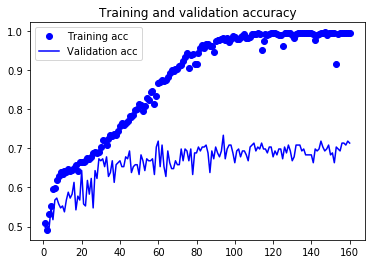

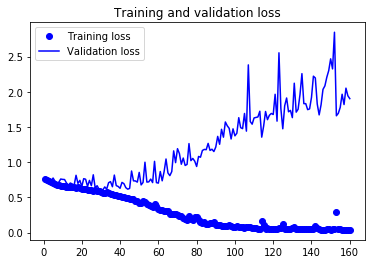

Model2_r0001_1024_use55False_l20.00025_ep160_bch64
Test: Accuracy mean/std - 0.6533605456352234/0.043338876217603683
Test: Loss mean/std - 1.2720091905444861/0.5003357061943923
Train: Accuracy mean/std - 0.8829553723335266/0.13263146579265594
Train: Loss mean/std - 0.2700802736807215/0.2311737028474017


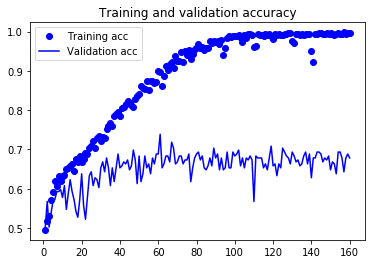

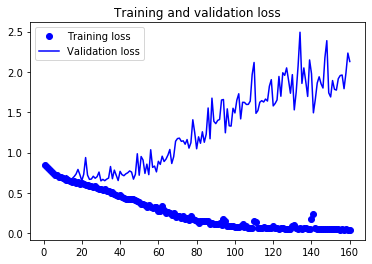

Model2_r0001_1024_use55False_l20.0005_ep160_bch64
Test: Accuracy mean/std - 0.6360238790512085/0.03956237807869911
Test: Loss mean/std - 1.3057050455361605/0.5378561851929464
Train: Accuracy mean/std - 0.8735736608505249/0.1428046077489853
Train: Loss mean/std - 0.2877395519636837/0.25408917630671435


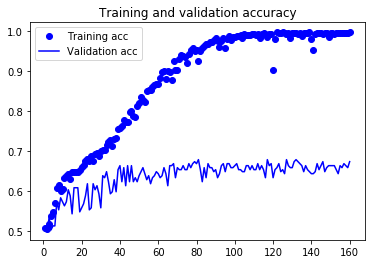

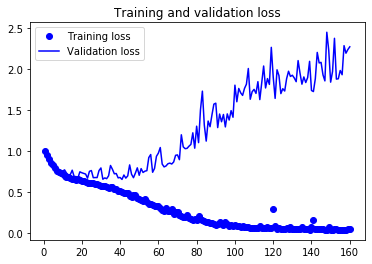

Model2_r0001_1024_use55False_l20.00075_ep160_bch64
Test: Accuracy mean/std - 0.6246544718742371/0.03820829838514328
Test: Loss mean/std - 1.3640980672091245/0.6013234035791856
Train: Accuracy mean/std - 0.864464282989502/0.14327220618724823
Train: Loss mean/std - 0.31059460482706447/0.2646550299383552


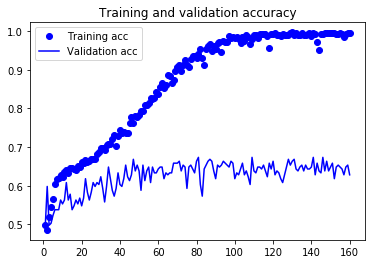

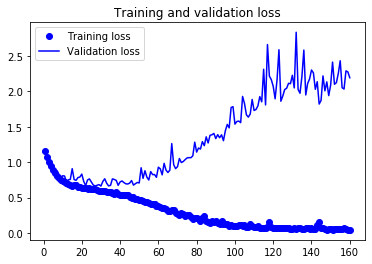

Model2_r0001_1024_use55False_l20.001_ep160_bch64
Test: Accuracy mean/std - 0.6479899883270264/0.047671861946582794
Test: Loss mean/std - 1.2350928843021394/0.49621653169242164
Train: Accuracy mean/std - 0.8732879757881165/0.1372239738702774
Train: Loss mean/std - 0.3070130919639154/0.27368951137978875


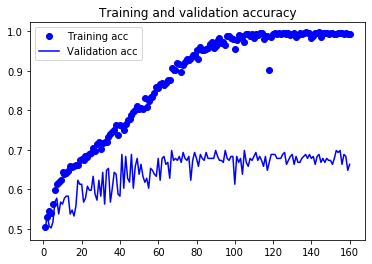

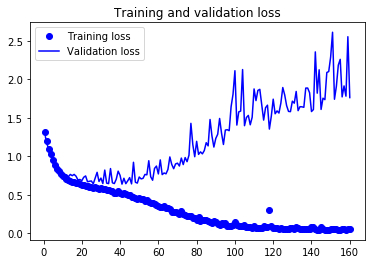

Model2_r0001_1024_use55True_l20.0001_ep160_bch64
Test: Accuracy mean/std - 0.6109610795974731/0.023133810609579086
Test: Loss mean/std - 1.9660514023154974/0.4812920452287185
Train: Accuracy mean/std - 0.9668415188789368/0.09130091220140457
Train: Loss mean/std - 0.08501830911579808/0.16564503577755063


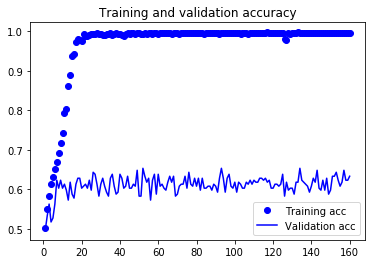

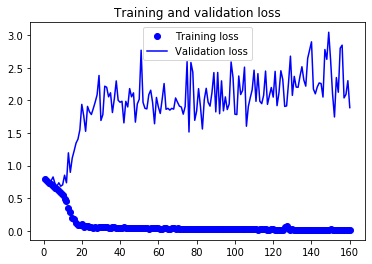

Model2_r0001_1024_use55True_l20.00025_ep160_bch64
Test: Accuracy mean/std - 0.6157663464546204/0.02151058427989483
Test: Loss mean/std - 2.0319957695901394/0.5286698956743098
Train: Accuracy mean/std - 0.9655960202217102/0.09481972455978394
Train: Loss mean/std - 0.09427767027472146/0.18379680174975713


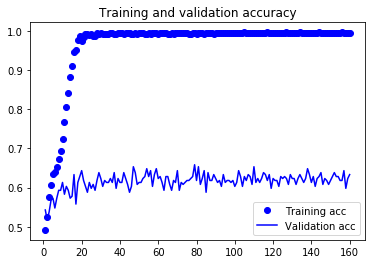

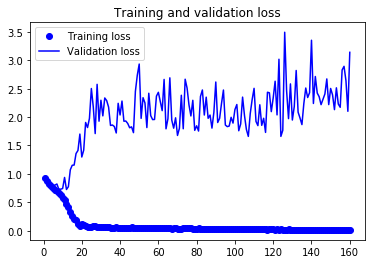

Model2_r0001_1024_use55True_l20.0005_ep160_bch64
Test: Accuracy mean/std - 0.5889133214950562/0.023337753489613533
Test: Loss mean/std - 1.844839347153902/0.40104188363731197
Train: Accuracy mean/std - 0.9603459239006042/0.10415880382061005
Train: Loss mean/std - 0.10780996472355245/0.22111413641546854


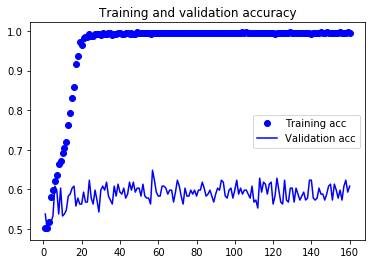

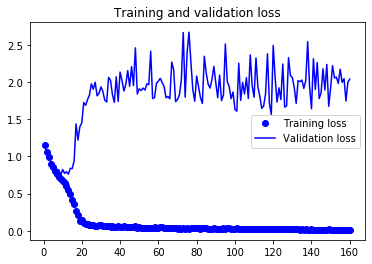

Model2_r0001_1024_use55True_l20.00075_ep160_bch64
Test: Accuracy mean/std - 0.5889447331428528/0.02094489149749279
Test: Loss mean/std - 1.9329328089952469/0.4642147266965513
Train: Accuracy mean/std - 0.9540178179740906/0.11162544786930084
Train: Loss mean/std - 0.12645234257975663/0.25387185392567196


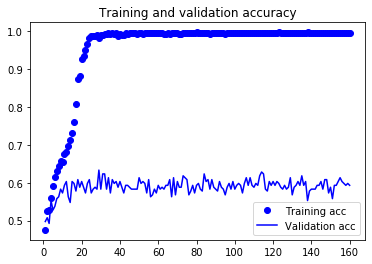

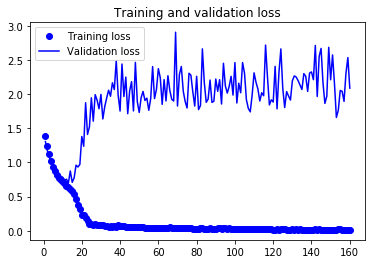

Model2_r0001_1024_use55True_l20.001_ep160_bch64
Test: Accuracy mean/std - 0.6028580665588379/0.016660982742905617
Test: Loss mean/std - 1.8519449573010207/0.37485996908895075
Train: Accuracy mean/std - 0.9671405553817749/0.09389888495206833
Train: Loss mean/std - 0.109305150689025/0.25777052682850893


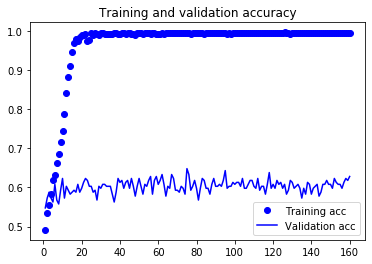

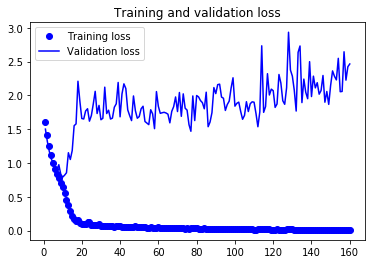

In [38]:
for k in histories:
    print(k)
    draw_evolution(histories[k])

Model2_r0001_u512_l10.0001_ep160_bch64
Test: Accuracy mean/std - 0.6148554682731628/0.0510190948843956
Test: Loss mean/std - 0.8175935097038746/0.19447406892067243
Train: Accuracy mean/std - 0.7786021828651428/0.0668715387582779
Train: Loss mean/std - 0.5954091747609598/0.2517825901117963


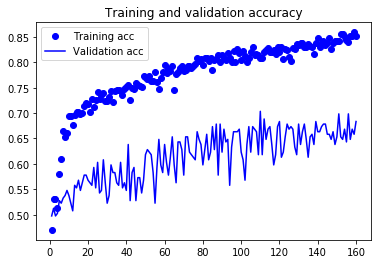

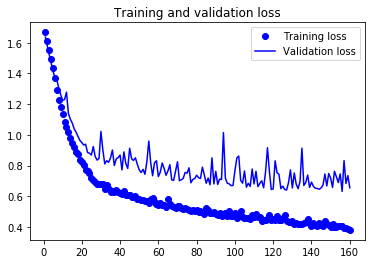

Model2_r0001_u512_l10.00025_ep160_bch64
Test: Accuracy mean/std - 0.6201947331428528/0.054617103189229965
Test: Loss mean/std - 0.934383612126112/0.4480629366295866
Train: Accuracy mean/std - 0.7726258635520935/0.06510061025619507
Train: Loss mean/std - 0.7205858164435446/0.5232830758822175


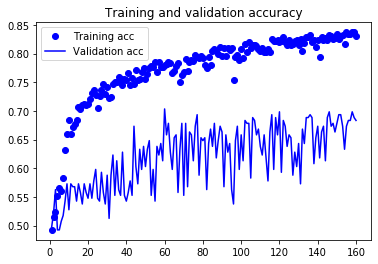

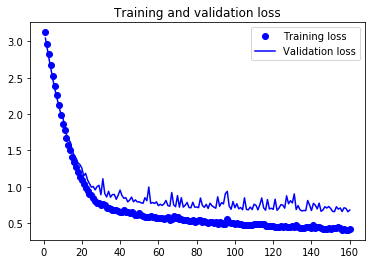

Model2_r0001_u512_l10.0005_ep160_bch64
Test: Accuracy mean/std - 0.6213253736495972/0.05723005160689354
Test: Loss mean/std - 1.094840144738555/0.8946853989964294
Train: Accuracy mean/std - 0.7691097855567932/0.06451747566461563
Train: Loss mean/std - 0.9060356630646484/0.9809636427423296


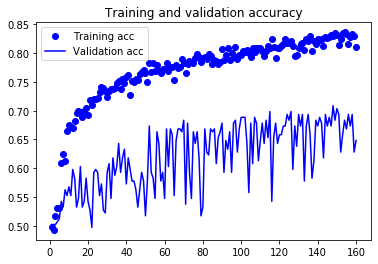

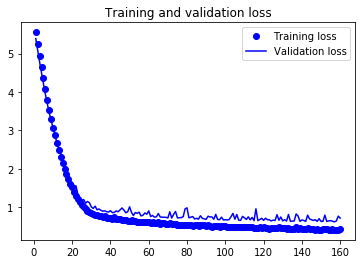

Model2_r0001_u512_l10.00075_ep160_bch64
Test: Accuracy mean/std - 0.6283291578292847/0.05608389154076576
Test: Loss mean/std - 1.2375910382717847/1.339296376237049
Train: Accuracy mean/std - 0.7737679481506348/0.06841294467449188
Train: Loss mean/std - 1.054773927458069/1.4482729097070723


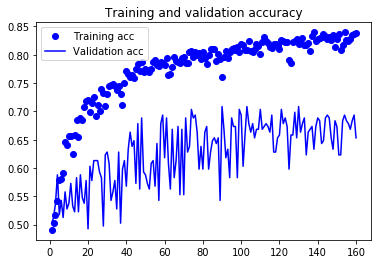

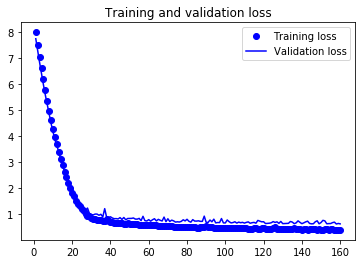

Model2_r0001_u512_l10.001_ep160_bch64
Test: Accuracy mean/std - 0.6140389442443848/0.057304881513118744
Test: Loss mean/std - 1.4211267426609993/1.789700192329936
Train: Accuracy mean/std - 0.7553582191467285/0.05601750314235687
Train: Loss mean/std - 1.256007788541525/1.9032958601334042


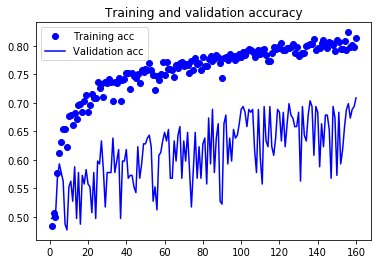

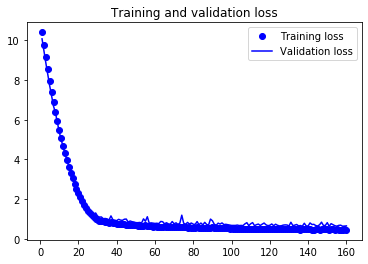

Model2_r0001_u1024_l10.0001_ep160_bch64
Test: Accuracy mean/std - 0.6157349348068237/0.04971104860305786
Test: Loss mean/std - 0.8516683004796505/0.27259128192290044
Train: Accuracy mean/std - 0.7842498421669006/0.07581927627325058
Train: Loss mean/std - 0.5989496926901785/0.3544393686242569


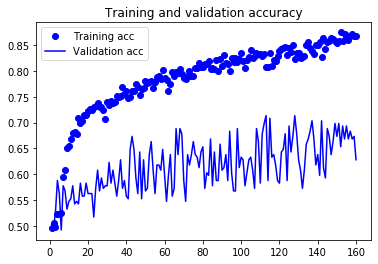

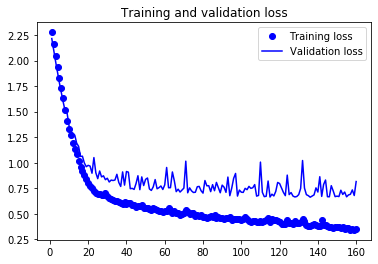

Model2_r0001_u1024_l10.00025_ep160_bch64
Test: Accuracy mean/std - 0.6262876391410828/0.056498099118471146
Test: Loss mean/std - 0.9652216259390116/0.6675901956174379
Train: Accuracy mean/std - 0.7765175104141235/0.06998275965452194
Train: Loss mean/std - 0.7515288428537483/0.7578293311575954


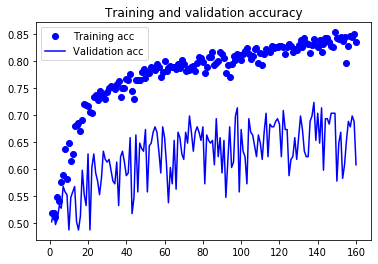

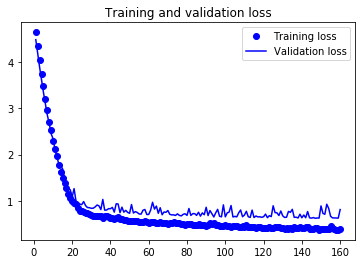

Model2_r0001_u1024_l10.0005_ep160_bch64
Test: Accuracy mean/std - 0.6197236776351929/0.049849364906549454
Test: Loss mean/std - 1.1845464996993542/1.3187006832695911
Train: Accuracy mean/std - 0.7668296098709106/0.060722652822732925
Train: Loss mean/std - 1.0067839262151488/1.4357561527398701


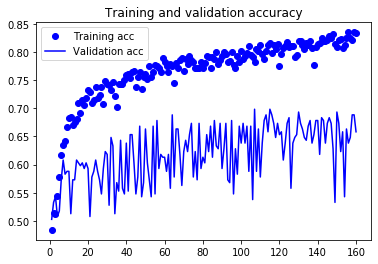

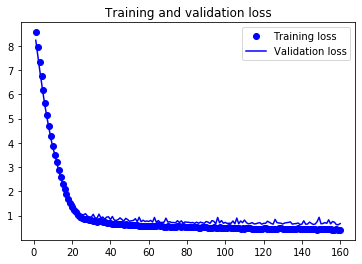

Model2_r0001_u1024_l10.00075_ep160_bch64
Test: Accuracy mean/std - 0.628831684589386/0.06137416884303093
Test: Loss mean/std - 1.3239123690873384/1.982721708908682
Train: Accuracy mean/std - 0.76225745677948/0.06575187295675278
Train: Loss mean/std - 1.1813438784864934/2.1329284004356808


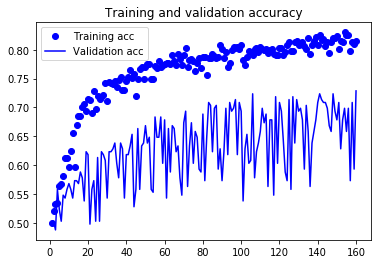

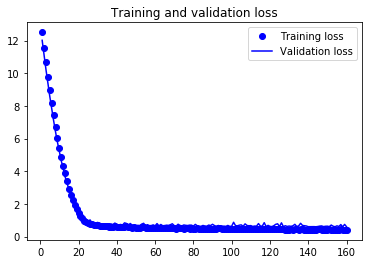

Model2_r0001_u1024_l10.001_ep160_bch64
Test: Accuracy mean/std - 0.6141331791877747/0.05638839304447174
Test: Loss mean/std - 1.5910743609070779/2.6376617795631714
Train: Accuracy mean/std - 0.7615730166435242/0.06107865646481514
Train: Loss mean/std - 1.4444466592846568/2.822223880135442


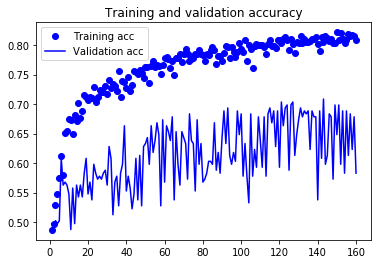

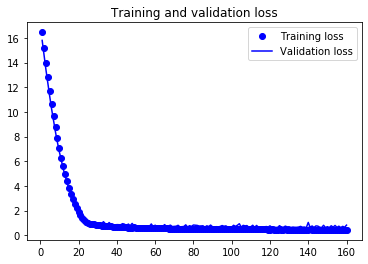

In [33]:
for k in histories:
    print(k)
    draw_evolution(histories[k])

Model2_r0.0009_l256_ep120_bch64
Test: Accuracy mean/std - 0.5842545628547668/0.03695964068174362
Test: Loss mean/std - 1.6627515201767287/0.7846220838432068
Train: Accuracy mean/std - 0.8996245265007019/0.11319734156131744
Train: Loss mean/std - 0.20259504199614273/0.20265662730549677


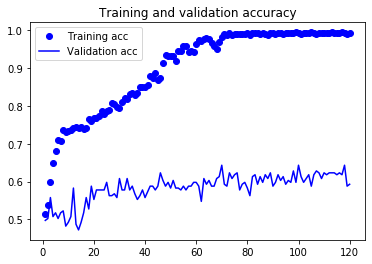

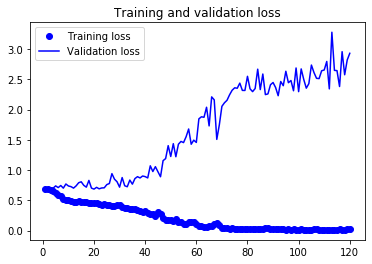

Model2_r0.001_l256_ep120_bch64
Test: Accuracy mean/std - 0.6083751916885376/0.05074603110551834
Test: Loss mean/std - 1.2889760608474414/0.5684636496499302
Train: Accuracy mean/std - 0.881805419921875/0.11504247039556503
Train: Loss mean/std - 0.24061846563995998/0.20498565803185625


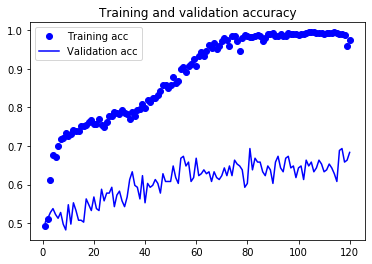

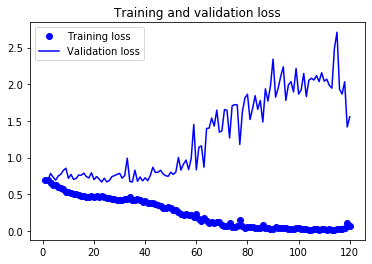

Model2_r0.0001_l512_ep120_bch64
Test: Accuracy mean/std - 0.6268844604492188/0.05848121643066406
Test: Loss mean/std - 0.6861371104915936/0.07162672567390087
Train: Accuracy mean/std - 0.7845900654792786/0.07803082466125488
Train: Loss mean/std - 0.438333666102217/0.10292311982689593


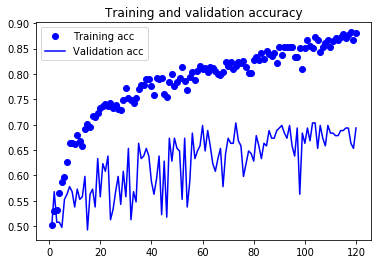

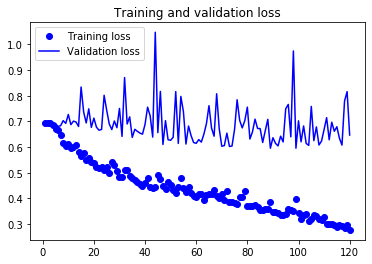

Model2_r0.0003_l512_ep120_bch64
Test: Accuracy mean/std - 0.5963148474693298/0.03757287189364433
Test: Loss mean/std - 1.0722756351033846/0.43004456089160636
Train: Accuracy mean/std - 0.8623278737068176/0.11266849935054779
Train: Loss mean/std - 0.2861316462916725/0.19589379028457435


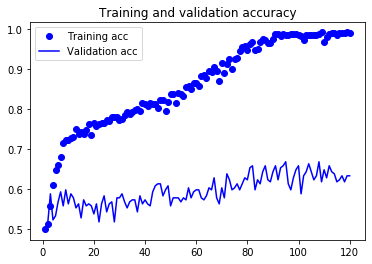

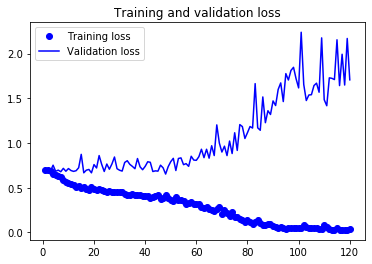

Model2_r0.0006_l512_ep120_bch64
Test: Accuracy mean/std - 0.638274610042572/0.06968450546264648
Test: Loss mean/std - 1.0715517645080885/0.3462938418452625
Train: Accuracy mean/std - 0.88942950963974/0.11901986598968506
Train: Loss mean/std - 0.2241598481622993/0.21225085746918168


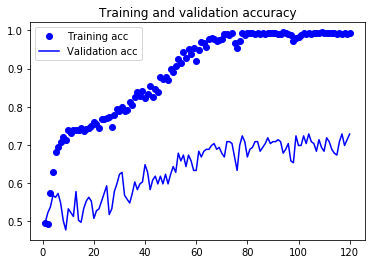

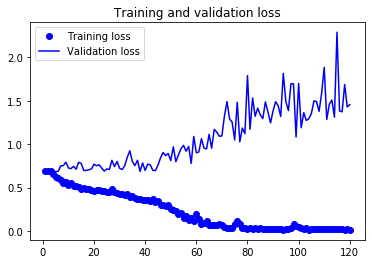

Model2_r0.0009_l512_ep120_bch64
Test: Accuracy mean/std - 0.593216061592102/0.036398064345121384
Test: Loss mean/std - 1.4077578485012054/0.5485060068380291
Train: Accuracy mean/std - 0.9059501886367798/0.11152402311563492
Train: Loss mean/std - 0.19194777195468973/0.20231141497099783


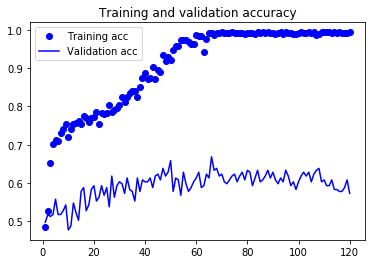

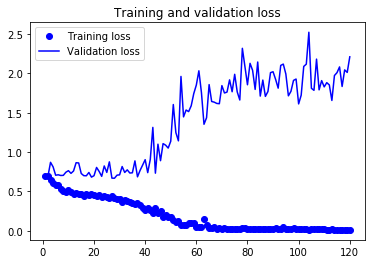

Model2_r0.001_l512_ep120_bch64
Test: Accuracy mean/std - 0.5862646698951721/0.030215825885534286
Test: Loss mean/std - 1.4924425770839056/0.8178307162892642
Train: Accuracy mean/std - 0.8715268969535828/0.12415504455566406
Train: Loss mean/std - 0.254190327341357/0.21514096143533662


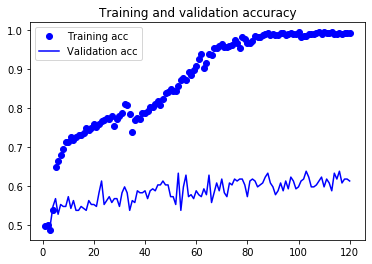

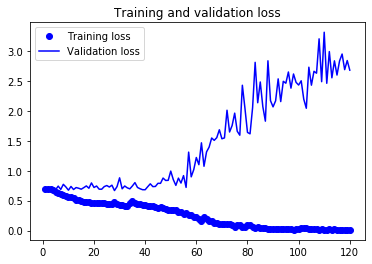

Model2_r0.0001_l1024_ep120_bch64
Test: Accuracy mean/std - 0.6136515140533447/0.04183339700102806
Test: Loss mean/std - 0.7224165285627048/0.11977849728262573
Train: Accuracy mean/std - 0.806607186794281/0.09205734729766846
Train: Loss mean/std - 0.3917707174916938/0.12938655199240343


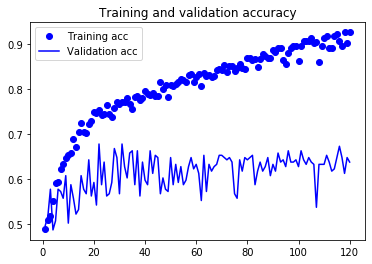

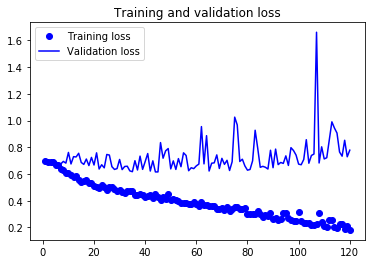

Model2_r0.0006_l1024_ep120_bch64
Test: Accuracy mean/std - 0.5970268249511719/0.04894575476646423
Test: Loss mean/std - 1.2473572795589765/0.5047942370529293
Train: Accuracy mean/std - 0.8853409886360168/0.11900072544813156
Train: Loss mean/std - 0.2335822636636314/0.20878157585589122


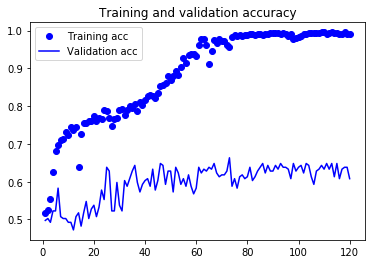

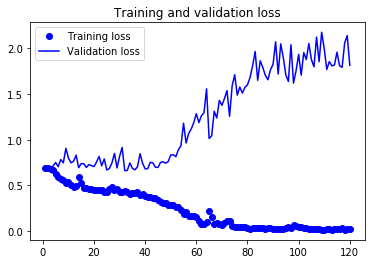

Model2_r0.0009_l1024_ep120_bch64
Test: Accuracy mean/std - 0.5491625070571899/0.027132447808980942
Test: Loss mean/std - 1.5006342122952143/0.814129230114442
Train: Accuracy mean/std - 0.8752607107162476/0.11856553703546524
Train: Loss mean/std - 0.2533069100978404/0.20830203265534755


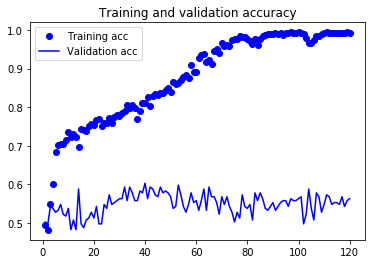

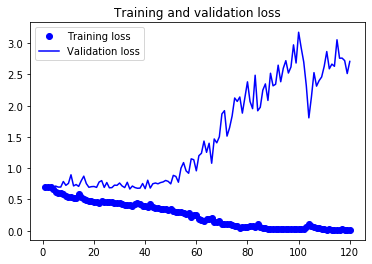

Model2_r0.001_l1024_ep120_bch64
Test: Accuracy mean/std - 0.5900334715843201/0.04583428427577019
Test: Loss mean/std - 1.5074169089396794/0.7423944134228888
Train: Accuracy mean/std - 0.881805419921875/0.11974139511585236
Train: Loss mean/std - 0.23319856366726285/0.20695512119372658


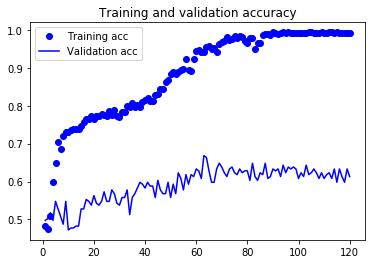

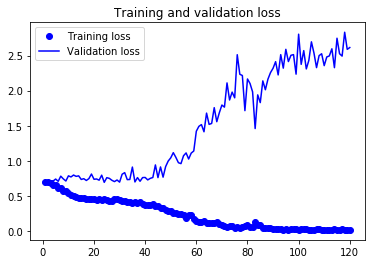

In [23]:
for k in histories:
    print(k)
    draw_evolution(histories[k])


Test: Accuracy mean/std - 0.5789782404899597/0.030478280037641525
Test: Loss mean/std - 1.399445538719495/0.6544016661646024
Train: Accuracy mean/std - 0.8862537145614624/0.11638911813497543
Train: Loss mean/std - 0.2327695270175014/0.2071416216773456


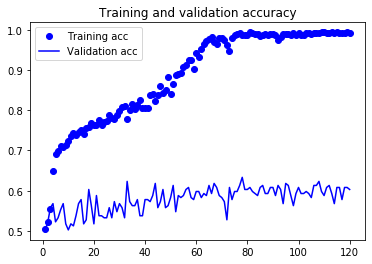

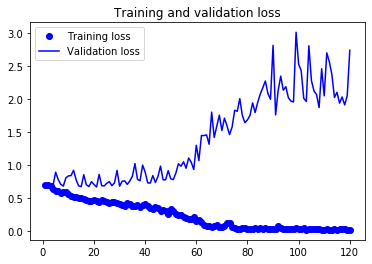

In [17]:
draw_evolution(history)

Test: Accuracy mean/std - 0.668121874332428/0.050727479159832
Test: Loss mean/std - 1.101547484844923/0.34699296148957665
Train: Accuracy mean/std - 0.9185739755630493/0.11052185297012329
Train: Loss mean/std - 0.17225113678067644/0.19919435663426394


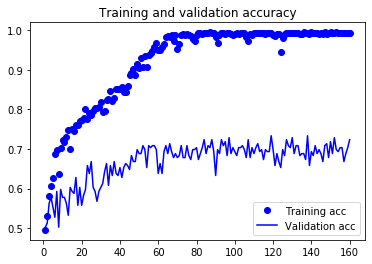

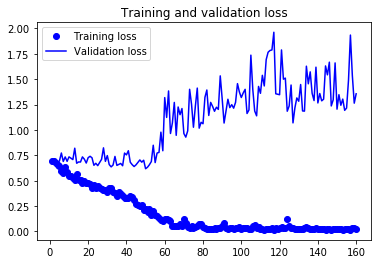

In [156]:
draw_evolution(history)

In [153]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 3.5484 - accuracy: 0.4872


[3.54839825630188, 0.4871795]

In [157]:
name_of_model = 'Model2_r0003_ep160h64_a74_b72_c74_d70_e48'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0003_ep160h64_a74_b72_c74_d70_e48\assets


'./TempModels/2\\Model2_r0003_ep160h64_a74_b72_c74_d70_e48'

Test: Accuracy mean/std - 0.5906298756599426/0.03751164302229881
Test: Loss mean/std - 0.8361543079819342/0.20205733115620875
Train: Accuracy mean/std - 0.8149074912071228/0.09531571716070175
Train: Loss mean/std - 0.3794502375309965/0.14794163802717827


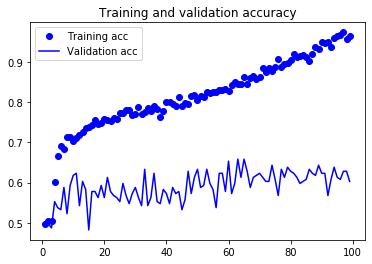

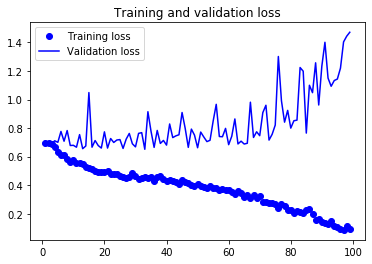

In [149]:
draw_evolution(history)

In [147]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 3.2548 - accuracy: 0.4103


[3.254765033721924, 0.41025642]

In [148]:
name_of_model = 'Model2_r0003_ep100_bch64_a72_b64_c67_d60_e41'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0003_ep100_bch64_a72_b64_c67_d60_e41\assets


'./TempModels/2\\Model2_r0003_ep100_bch64_a72_b64_c67_d60_e41'

Test: Accuracy mean/std - 0.6220895051956177/0.040406081825494766
Test: Loss mean/std - 0.7085020710660525/0.09416223295089117
Train: Accuracy mean/std - 0.8232378959655762/0.08510700613260269
Train: Loss mean/std - 0.3643739835183685/0.12743962297191178


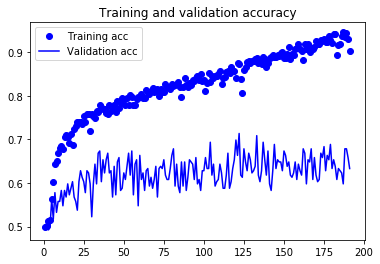

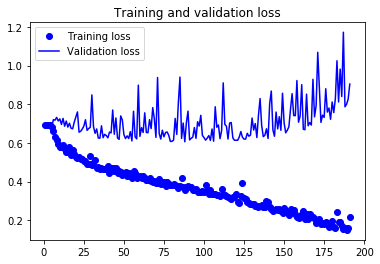

In [141]:
draw_evolution(history)

In [142]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 1.8128 - accuracy: 0.4487


[1.8127896785736084, 0.44871795]

In [143]:
name_of_model = 'Model2_r0001_ep190_bch64_a67_b66_c71_d66_e44'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0001_ep190_bch64_a67_b66_c71_d66_e44\assets


'./TempModels/2\\Model2_r0001_ep190_bch64_a67_b66_c71_d66_e44'

Test: Accuracy mean/std - 0.6099245548248291/0.04153493419289589
Test: Loss mean/std - 0.6813198963801066/0.06598311259407698
Train: Accuracy mean/std - 0.7779359817504883/0.07498498260974884
Train: Loss mean/std - 0.44056881849122115/0.0941113608687484


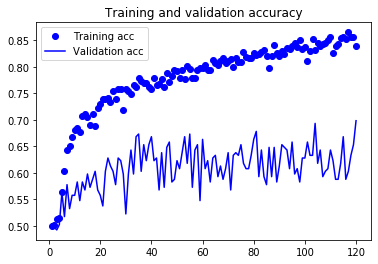

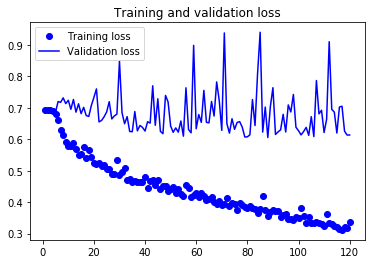

In [139]:
draw_evolution(history)

In [137]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 4s 4s/step - loss: 1.1724 - accuracy: 0.5256


[1.172392725944519, 0.525641]

In [138]:
name_of_model = 'Model2_r0001_ep120_bch64_a67_b69_c67_d71_e52'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_r0001_ep120_bch64_a67_b69_c67_d71_e52\assets


'./TempModels/2\\Model2_r0001_ep120_bch64_a67_b69_c67_d71_e52'

Test: Accuracy mean/std - 0.586599588394165/0.05604285001754761
Test: Loss mean/std - 0.9776685694853465/0.3939285584415976
Train: Accuracy mean/std - 0.8035985231399536/0.12273361533880234
Train: Loss mean/std - 0.3967578524542828/0.21677356370151515


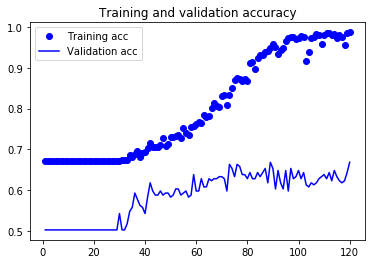

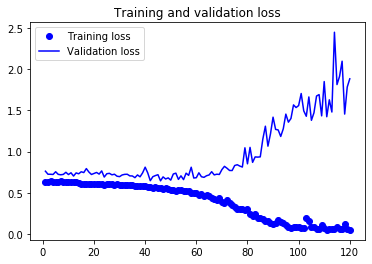

In [126]:
draw_evolution(history)

In [127]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 10s 10s/step - loss: 4.0191 - accuracy: 0.4615


[4.0190582275390625, 0.46153846]

In [ ]:
name_of_model = 'Model2_0001_ep120_bch32_a_b_c_d_e'
SaveModel(model,name_of_model)

Test: Accuracy mean/std - 0.5983425378799438/0.0441390760242939
Test: Loss mean/std - 1.1744098161396228/0.3013368071761936
Train: Accuracy mean/std - 0.8449816107749939/0.12957729399204254
Train: Loss mean/std - 0.5011485695742081/0.3970638155875498


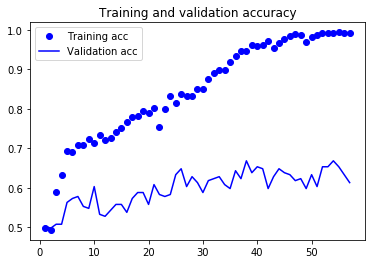

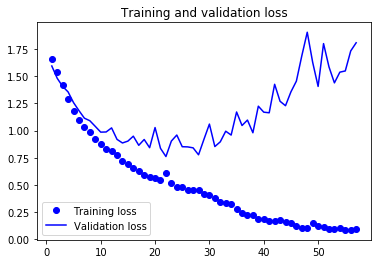

In [116]:
draw_evolution(history)

In [117]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 9s 9s/step - loss: 3.1412 - accuracy: 0.4872


[3.1411843299865723, 0.4871795]

In [118]:
name_of_model = 'Model2_Aver_1024_0001_l2001_ep57_bch64_a71_b63_c65_d64_e48'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_Aver_1024_0001_l2001_ep57_bch64_a71_b63_c65_d64_e48\assets


'./TempModels/2\\Model2_Aver_1024_0001_l2001_ep57_bch64_a71_b63_c65_d64_e48'

Test: Accuracy mean/std - 0.5859041810035706/0.04644664004445076
Test: Loss mean/std - 0.831729605228086/0.18318800183069822
Train: Accuracy mean/std - 0.8167487978935242/0.09942915290594101
Train: Loss mean/std - 0.37060560821523464/0.16165127157292336


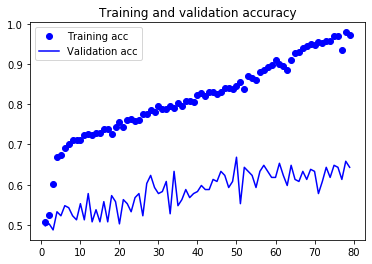

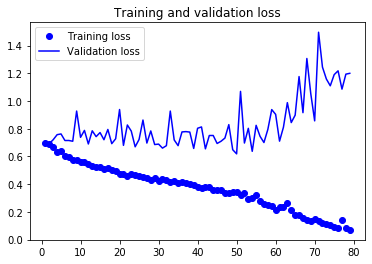

In [110]:
draw_evolution(history)

Test: Accuracy mean/std - 0.5351758003234863/0.03481173515319824
Test: Loss mean/std - 0.8684505665743792/0.21895224488986356
Train: Accuracy mean/std - 0.7148750424385071/0.15288880467414856
Train: Loss mean/std - 0.5382182844591363/0.28971108140056356


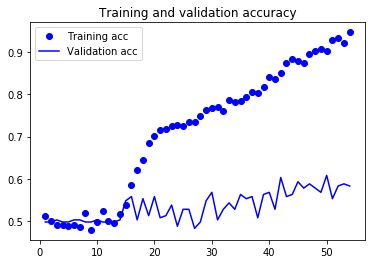

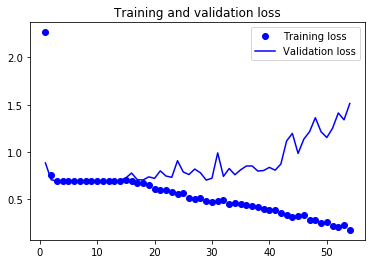

In [103]:
draw_evolution(history)

In [101]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 10s 10s/step - loss: 2.5783 - accuracy: 0.4487


[2.578274965286255, 0.44871795]

In [102]:
name_of_model = 'Model2_512_001_l201_ep54_bch32_a65_b59_c65_d55_e44'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_512_001_l201_ep54_bch32_a65_b59_c65_d55_e44\assets


'./TempModels/2\\Model2_512_001_l201_ep54_bch32_a65_b59_c65_d55_e44'

Test: Accuracy mean/std - 0.49979063868522644/0.0025038346648216248
Test: Loss mean/std - 0.693673895051082/0.0035514911273878272
Train: Accuracy mean/std - 0.490795761346817/0.00801998469978571
Train: Loss mean/std - 0.7118232926578386/0.12682884437169134


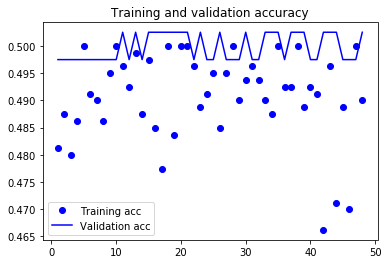

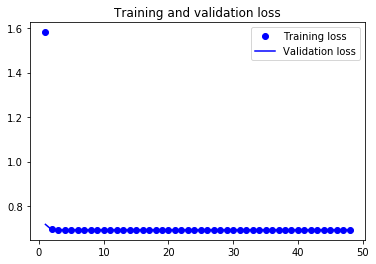

In [94]:
draw_evolution(history)

In [95]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 10s 10s/step - loss: 0.6932 - accuracy: 0.5000


[0.6931523680686951, 0.5]

In [96]:
name_of_model = 'Model2_512_001_l201_ep50_bch16_a33_b49_c50_d50_e50'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_512_001_l201_ep50_bch16_a33_b49_c50_d50_e50\assets


'./TempModels/2\\Model2_512_001_l201_ep50_bch16_a33_b49_c50_d50_e50'

Test: Accuracy mean/std - 0.552763819694519/0.03222263604402542
Test: Loss mean/std - 1.174491211771965/0.5431341012084231
Train: Accuracy mean/std - 0.8326584696769714/0.13109219074249268
Train: Loss mean/std - 0.37192179658993557/0.3336900776892232


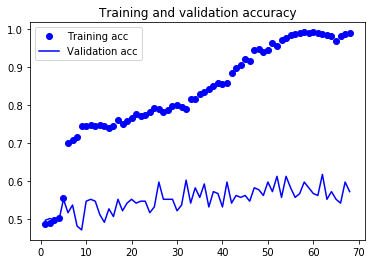

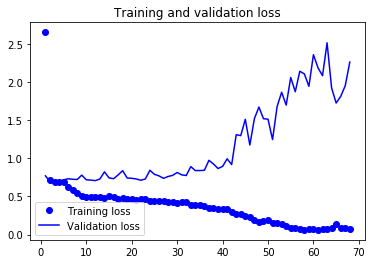

In [87]:
draw_evolution(history)

In [88]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 10s 10s/step - loss: 4.3893 - accuracy: 0.4231


[4.389348030090332, 0.42307693]

In [89]:
name_of_model = 'Model2_fined_512_0005_l2005_ep70_bch32_a69_b60_c64_d58_e42'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_fined_512_0005_l2005_ep70_bch32_a69_b60_c64_d58_e42\assets


'./TempModels/2\\Model2_fined_512_0005_l2005_ep70_bch32_a69_b60_c64_d58_e42'

Test: Accuracy mean/std - 0.5868878960609436/0.027213871479034424
Test: Loss mean/std - 1.0438130705855613/0.27917986650181803
Train: Accuracy mean/std - 0.8811160326004028/0.10256370157003403
Train: Loss mean/std - 0.2854095466902718/0.18257638964928638


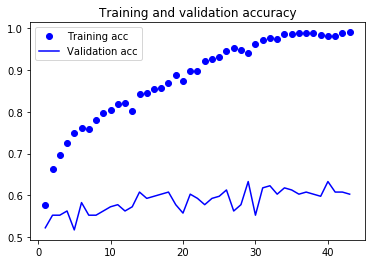

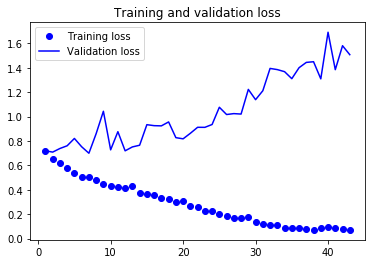

In [81]:
draw_evolution(history)

Test: Accuracy mean/std - 0.6089614629745483/0.022871991619467735
Test: Loss mean/std - 1.3204783538977305/0.31609899811907943
Train: Accuracy mean/std - 0.9294535517692566/0.10238738358020782
Train: Loss mean/std - 0.2722271336830024/0.3674328848055607


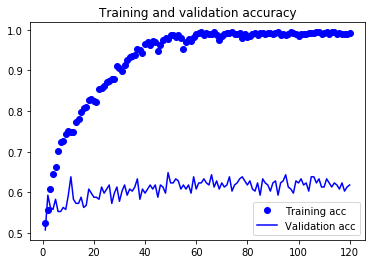

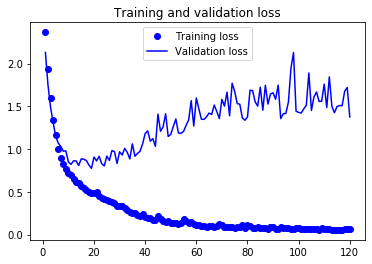

In [76]:
draw_evolution(history)

Test: Accuracy mean/std - 0.6524706482887268/0.06236016005277634
Test: Loss mean/std - 1.623106330136458/0.5964217948171227
Train: Accuracy mean/std - 0.9248539805412292/0.11366390436887741
Train: Loss mean/std - 0.1525508192912535/0.21093590585386682


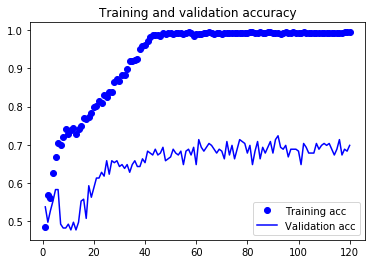

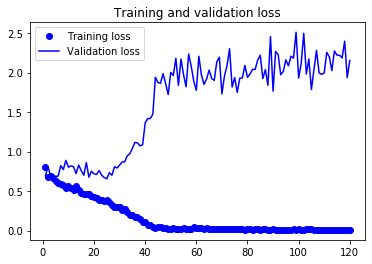

In [68]:
draw_evolution(history)

In [69]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 4s 4s/step - loss: 5.0054 - accuracy: 0.5385


[5.005425453186035, 0.53846157]

In [70]:
name_of_model = 'Model2_512_001_ep120_bch128_a76_b69_c67_d71_e53'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_512_001_ep120_bch128_a76_b69_c67_d71_e53\assets


'./TempModels/2\\Model2_512_001_ep120_bch128_a76_b69_c67_d71_e53'

Test: Accuracy mean/std - 0.6114664673805237/0.028953952714800835
Test: Loss mean/std - 1.4932127291505988/0.4380822217664362
Train: Accuracy mean/std - 0.9457960724830627/0.09454911947250366
Train: Loss mean/std - 0.12160768793135385/0.17237581658177883


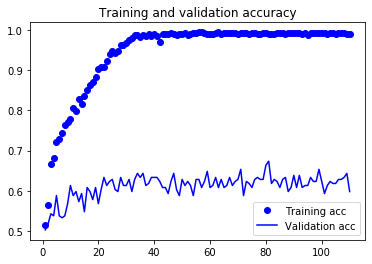

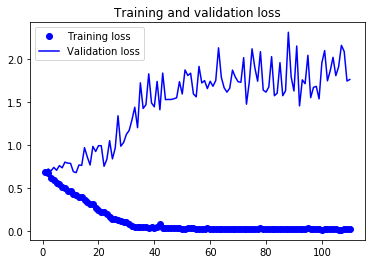

In [63]:
draw_evolution(history)

In [61]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 2.6431 - accuracy: 0.5000


[2.643106698989868, 0.5]

In [62]:
name_of_model = 'Model2_512_0001_ep110_bch32_a66_b59_c61_d60_e50'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_512_0001_ep110_bch32_a66_b59_c61_d60_e50\assets


'./TempModels/2\\Model2_512_0001_ep110_bch32_a66_b59_c61_d60_e50'

Test: Accuracy mean/std - 0.6211892366409302/0.04820884019136429
Test: Loss mean/std - 1.3614029909173648/0.49283378095782493
Train: Accuracy mean/std - 0.9115613102912903/0.10264014452695847
Train: Loss mean/std - 0.4009088981741613/2.0595187381015743


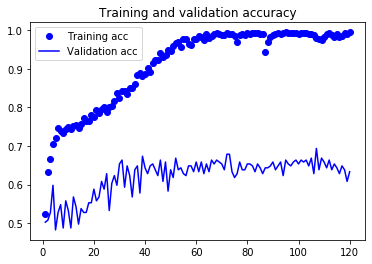

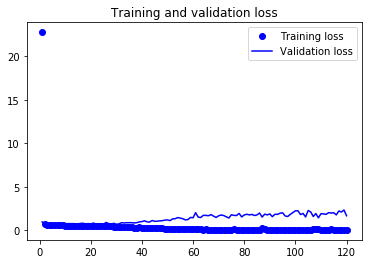

In [55]:
draw_evolution(history)

In [53]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 4s 4s/step - loss: 3.2452 - accuracy: 0.4872


[3.245234489440918, 0.4871795]

In [54]:
name_of_model = 'Model2_1024_0005_l205_ep120_bch32_a64_b63_c65_d64_e48'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_1024_0005_l205_ep120_bch32_a64_b63_c65_d64_e48\assets


'./TempModels/2\\Model2_1024_0005_l205_ep120_bch32_a64_b63_c65_d64_e48'

Test: Accuracy mean/std - 0.6215927004814148/0.057826802134513855
Test: Loss mean/std - 1.1550035142537318/0.4144672335079299
Train: Accuracy mean/std - 0.8790627717971802/0.12760859727859497
Train: Loss mean/std - 0.3468632749822419/0.6622850762135969


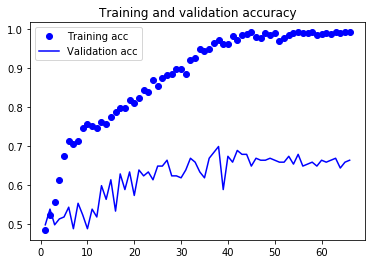

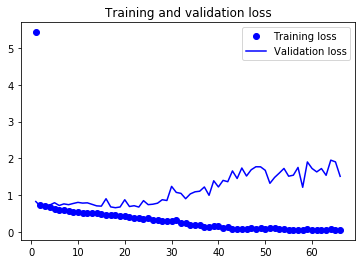

In [46]:
draw_evolution(history)

In [45]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 2.5073 - accuracy: 0.4872


[2.507343053817749, 0.4871795]

In [47]:
name_of_model = 'Model2_1024_0005_l201_ep67_bch32_a72_b68_c65_d68_e48'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_1024_0005_l201_ep67_bch32_a72_b68_c65_d68_e48\assets


'./TempModels/2\\Model2_1024_0005_l201_ep67_bch32_a72_b68_c65_d68_e48'

Test: Accuracy mean/std - 0.6012563109397888/0.05518360063433647
Test: Loss mean/std - 1.005750415722529/0.3093157645366066
Train: Accuracy mean/std - 0.8574467897415161/0.11369901895523071
Train: Loss mean/std - 0.37336463385840907/0.4177610838125139


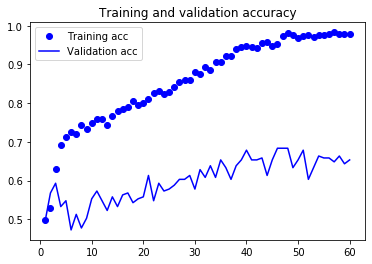

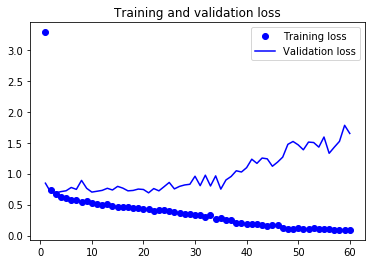

In [32]:
draw_evolution(history)

In [33]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 2.9987 - accuracy: 0.4872


[2.9986937046051025, 0.4871795]

In [34]:
name_of_model = 'Model2_1024_0005_l2005_Dr03_ep60_bch32_a70_b65_c66_d67_e48'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_1024_0005_l2005_Dr03_ep60_bch32_a70_b65_c66_d67_e48\assets


'./TempModels/2\\Model2_1024_0005_l2005_Dr03_ep60_bch32_a70_b65_c66_d67_e48'

Test: Accuracy mean/std - 0.5897612571716309/0.019819704815745354
Test: Loss mean/std - 1.5826368618756532/0.7406189758447715
Train: Accuracy mean/std - 0.9354153871536255/0.09928683936595917
Train: Loss mean/std - 0.35684377960251695/0.9869600483356166


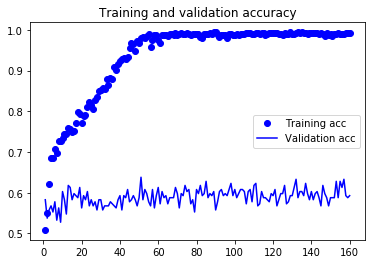

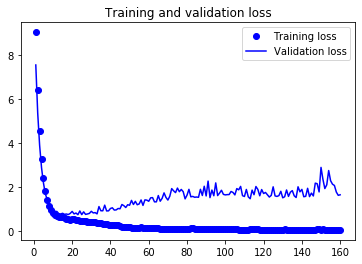

In [20]:
draw_evolution(history)

In [18]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 2.6591 - accuracy: 0.5256


[2.659147024154663, 0.525641]

In [19]:
name_of_model = 'Model2_512_0001_l201_ep160_bch64_a65_b59_c58_d60_e52'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./TempModels/2\Model2_512_0001_l201_ep160_bch64_a65_b59_c58_d60_e52\assets


'./TempModels/2\\Model2_512_0001_l201_ep160_bch64_a65_b59_c58_d60_e52'

Test: Accuracy mean/std - 0.6088358759880066/0.03253418207168579
Test: Loss mean/std - 1.4416969244678814/0.7964675169209343
Train: Accuracy mean/std - 0.9222204685211182/0.10857262462377548
Train: Loss mean/std - 0.4325836202975566/1.1091481229715983


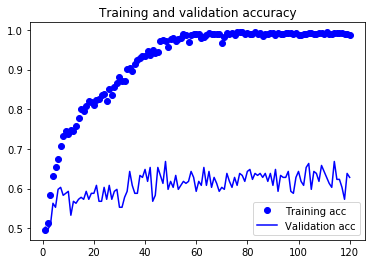

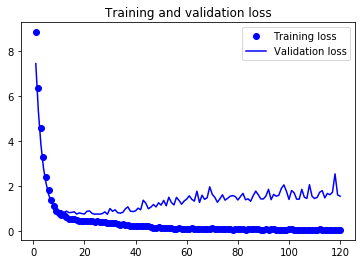

In [10]:
draw_evolution(history)

In [11]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)
model.evaluate(eval_gen5)

1/1 [==============================] - 3s 3s/step - loss: 3.0111 - accuracy: 0.4872


[3.0110628604888916, 0.4871795]

In [12]:
name_of_model = 'Model2_1024_0001_l2005_ep120_bch64_a62_b62_c65_d65_e48'
SaveModel(model,name_of_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./TempModels/2\Model2_1024_0001_l2005_ep120_bch64_a62_b62_c65_d65_e48\assets


'./TempModels/2\\Model2_1024_0001_l2005_ep120_bch64_a62_b62_c65_d65_e48'

# Classification 1 vs 2,3,4

Test: Accuracy mean/std - 0.5387336015701294/0.17514243721961975
Test: Loss mean/std - 1.3964285645633936/0.689374443964279
Train: Accuracy mean/std - 0.9542455673217773/0.07310210168361664
Train: Loss mean/std - 0.24904684651190703/0.8595044772008003


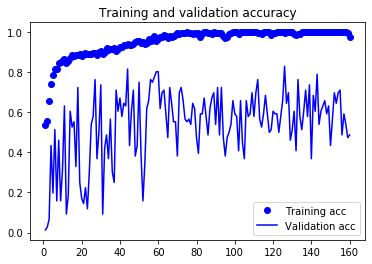

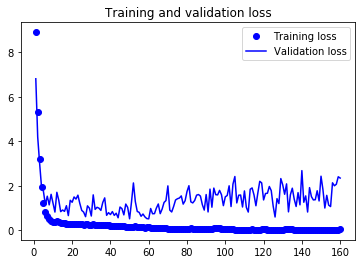

In [50]:
draw_evolution(history)

In [51]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 7s 7s/step - loss: 1.2293 - accuracy: 0.7200


[1.2292622327804565, 0.72]

In [52]:
name_of_model = 'Model5_1024_0001_l20055_ep160_bch64_a86_b48_c70_d72'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model5_1024_0001_l20055_ep160_bch64_a86_b48_c70_d72\assets


'./Models\\Model5_1024_0001_l20055_ep160_bch64_a86_b48_c70_d72'

Test: Accuracy mean/std - 0.6431743502616882/0.16430498659610748
Test: Loss mean/std - 1.1775646613910795/0.6101770795216177
Train: Accuracy mean/std - 0.9659274816513062/0.06871379166841507
Train: Loss mean/std - 0.21185456696650412/0.7340921912133037


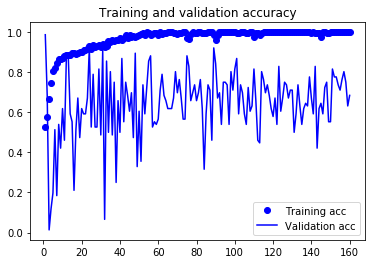

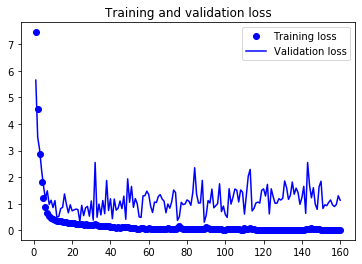

In [42]:
draw_evolution(history)

In [43]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 7s 7s/step - loss: 0.6922 - accuracy: 0.7933


[0.6922270655632019, 0.79333335]

In [44]:
name_of_model = 'Model5_1024_0001_l20045_ep160_bch64_a84_b68_c76_d79'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model5_1024_0001_l20045_ep160_bch64_a84_b68_c76_d79\assets


'./Models\\Model5_1024_0001_l20045_ep160_bch64_a84_b68_c76_d79'

Test: Accuracy mean/std - 0.6152412295341492/0.15758371353149414
Test: Loss mean/std - 1.2174039117991924/0.5081534135730513
Train: Accuracy mean/std - 0.9634925723075867/0.07128439843654633
Train: Loss mean/std - 0.19506615667698501/0.5108133634221242


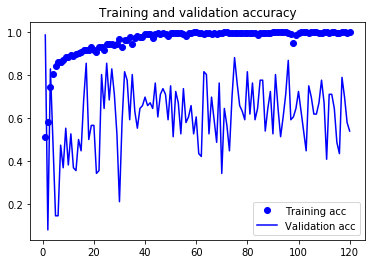

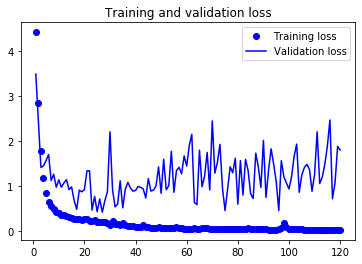

In [32]:
draw_evolution(history)

In [33]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 7s 7s/step - loss: 0.9449 - accuracy: 0.7533


[0.9448913931846619, 0.75333333]

In [34]:
name_of_model = 'Model5_1024_0001_l20025_ep120_sh_bch64_a84_b53_c71_75'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model5_1024_0001_l20025_ep120_sh_bch64_a84_b53_c71_75\assets


'./Models\\Model5_1024_0001_l20025_ep120_sh_bch64_a84_b53_c71_75'

Test: Accuracy mean/std - 0.5359649658203125/0.19006769359111786
Test: Loss mean/std - 1.230181399318907/0.7626317075509296
Train: Accuracy mean/std - 0.9365647435188293/0.07576955109834671
Train: Loss mean/std - 0.36994251810136897/1.0044649455238572


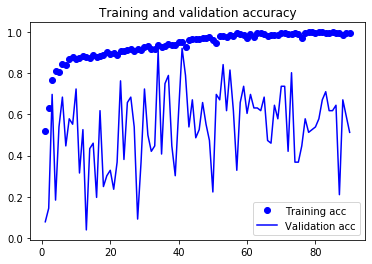

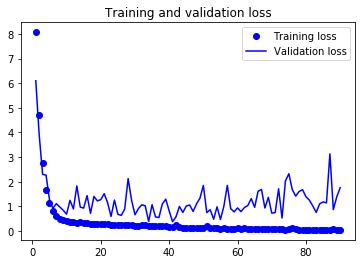

In [26]:
draw_evolution(history)

In [24]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 6s 6s/step - loss: 0.9497 - accuracy: 0.7333


[0.9497488141059875, 0.73333335]

In [25]:
name_of_model = 'Model5_v2_1024_0001_l2005_ep90_sh_bch64_a84_b51_c70_d73'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model5_v2_1024_0001_l2005_ep90_sh_bch64_a84_b51_c70_d73\assets


'./Models\\Model5_v2_1024_0001_l2005_ep90_sh_bch64_a84_b51_c70_d73'

Test: Accuracy mean/std - 0.44550439715385437/0.17706453800201416
Test: Loss mean/std - 1.9861971085270247/0.8037173147065116
Train: Accuracy mean/std - 0.9474571943283081/0.08296161890029907
Train: Loss mean/std - 0.1422785999793397/0.27421817312978397


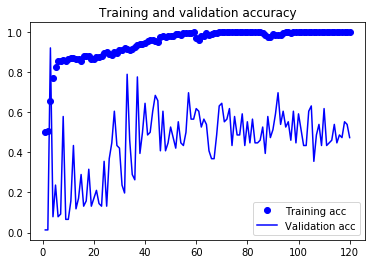

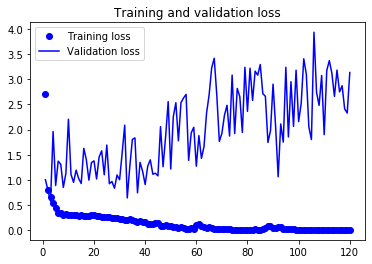

In [17]:
draw_evolution(history)

In [18]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 7s 7s/step - loss: 1.7187 - accuracy: 0.7067


[1.7187000513076782, 0.70666665]

In [19]:
name_of_model = 'Model5_1024_001_l2005_ep120_shuffle_bch64_a82_b47_c68_d70'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model5_1024_001_l2005_ep120_shuffle_bch64_a82_b47_c68_d70\assets


'./Models\\Model5_1024_001_l2005_ep120_shuffle_bch64_a82_b47_c68_d70'

Test: Accuracy mean/std - 0.5694078803062439/0.1660100370645523
Test: Loss mean/std - 1.2008266396820546/0.48648551887059577
Train: Accuracy mean/std - 0.9613951444625854/0.04391316697001457
Train: Loss mean/std - 0.1350420144220394/0.10484748394297974


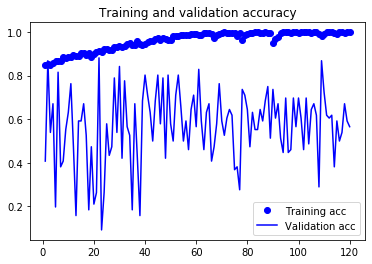

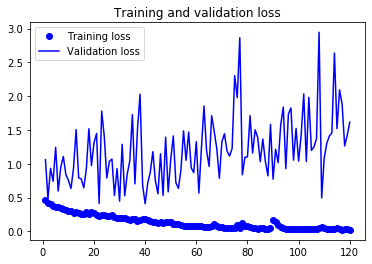

In [8]:
draw_evolution(history)

In [9]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 7s 7s/step - loss: 0.8810 - accuracy: 0.7467


[0.8809981942176819, 0.74666667]

In [11]:
name_of_model = 'Model5_1024_0001_l20075_ep120_shuffle_bch64_a84_b56_c72_d74'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model5_1024_0001_l20075_ep120_shuffle_bch64_a84_b56_c72_d74\assets


'./Models\\Model5_1024_0001_l20075_ep120_shuffle_bch64_a84_b56_c72_d74'

In [378]:
new_model = tf.keras.models.load_model('./Models/Model5_1024_0001_l201_ep37_shuffle_bch64_b98')

In [379]:
new_model.evaluate(eval_gen1)
new_model.evaluate(eval_gen2)
new_model.evaluate(eval_gen3)
new_model.evaluate(eval_gen4)

1/1 [==============================] - 7s 7s/step - loss: 11.4090 - accuracy: 0.5000


[11.408957481384277, 0.5]

Test: Accuracy mean/std - 0.40051349997520447/0.2544291913509369
Test: Loss mean/std - 1.6096130667663202/1.8225730207312447
Train: Accuracy mean/std - 0.8582059144973755/0.08469045162200928
Train: Loss mean/std - 1.0932941325856291/2.7187971864215426


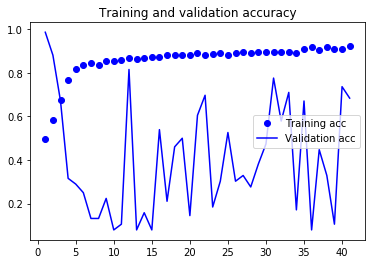

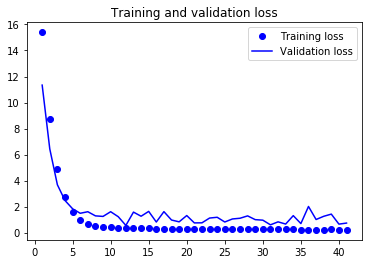

In [377]:
draw_evolution(history)

Test: Accuracy mean/std - 0.6197535395622253/0.18997471034526825
Test: Loss mean/std - 1.1122841437028934/1.0537478996863938
Train: Accuracy mean/std - 0.9489542245864868/0.06652773171663284
Train: Loss mean/std - 0.3536261678842222/1.4538463446061392


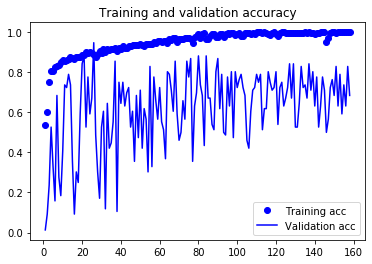

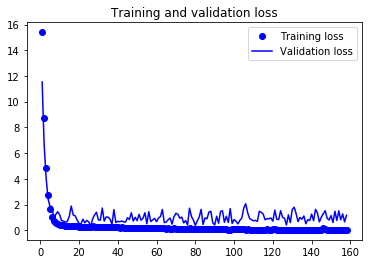

In [370]:
draw_evolution(history)

In [369]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 6s 6s/step - loss: 0.6412 - accuracy: 0.8000


[0.641241192817688, 0.8]

In [371]:
name_of_model = 'Model_5_1024_0001_l201_ep160_shuffle_bch64_a85_b68_c75_d80'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_1024_0001_l201_ep160_shuffle_bch64_a85_b68_c75_d80\assets


'./Models\\Model_5_1024_0001_l201_ep160_shuffle_bch64_a85_b68_c75_d80'

In [363]:
name_of_model = 'Model_5_1024_0001_l201_ep37_i26_shuffle_bch64_a85_b85_c84_d88'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_1024_0001_l201_ep37_i26_shuffle_bch64_a85_b85_c84_d88\assets


'./Models\\Model_5_1024_0001_l201_ep37_i26_shuffle_bch64_a85_b85_c84_d88'

Test: Accuracy mean/std - 0.47368425130844116/0.26203709840774536
Test: Loss mean/std - 1.6890765994787216/2.2046340549681287
Train: Accuracy mean/std - 0.8451598882675171/0.081288643181324
Train: Loss mean/std - 1.420429190493259/3.1159305488219307


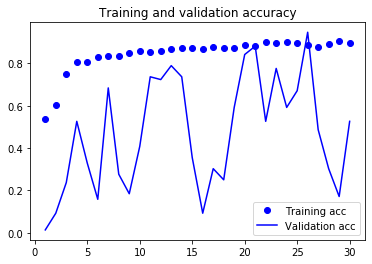

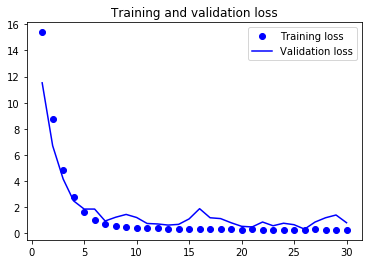

In [351]:
draw_evolution(history)

In [352]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 6s 6s/step - loss: 0.4865 - accuracy: 0.7267


[0.48646703362464905, 0.7266667]

In [353]:
name_of_model = 'Model_5_1024_0001_l201_ep30_i26_shuffle_bch64_a84_b52_c70_d72'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_1024_0001_l201_ep30_i26_shuffle_bch64_a84_b52_c70_d72\assets


'./Models\\Model_5_1024_0001_l201_ep30_i26_shuffle_bch64_a84_b52_c70_d72'

Test: Accuracy mean/std - 0.41644734144210815/0.2581186890602112
Test: Loss mean/std - 2.138630124926567/2.576465903300782
Train: Accuracy mean/std - 0.8207912445068359/0.08999185264110565
Train: Loss mean/std - 1.9934246348737663/3.684896382391983


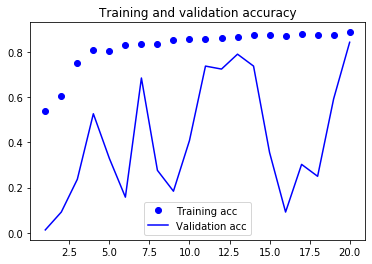

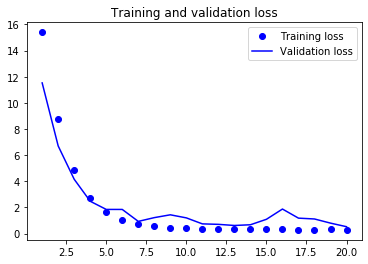

In [349]:
draw_evolution(history)

In [347]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 7s 7s/step - loss: 0.4361 - accuracy: 0.8533


[0.43614140152931213, 0.85333335]

In [348]:
name_of_model = 'Model_5_1024_0001_l201_ep20_shuffle_bch64_a80_b84_c80_d85'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_1024_0001_l201_ep20_shuffle_bch64_a80_b84_c80_d85\assets


'./Models\\Model_5_1024_0001_l201_ep20_shuffle_bch64_a80_b84_c80_d85'

Test: Accuracy mean/std - 0.5506578683853149/0.1663806140422821
Test: Loss mean/std - 1.1339775770902634/0.35942140976956094
Train: Accuracy mean/std - 0.9294542670249939/0.08605353534221649
Train: Loss mean/std - 0.2743541996608311/0.33138986394994846


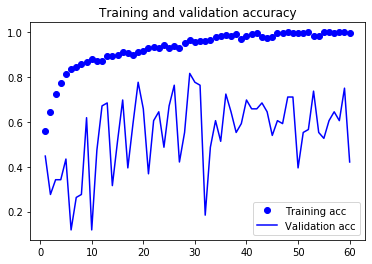

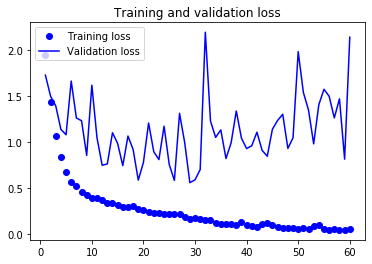

In [337]:
draw_evolution(history)

Test: Accuracy mean/std - 0.5684210062026978/0.1534799337387085
Test: Loss mean/std - 1.282803896665573/0.44895467946525514
Train: Accuracy mean/std - 0.9561912417411804/0.07440385967493057
Train: Loss mean/std - 0.18187453986355653/0.2808036854223145


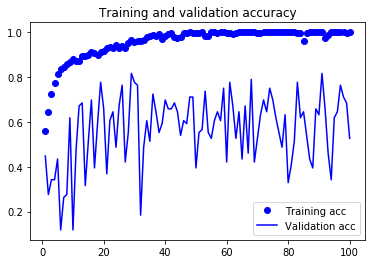

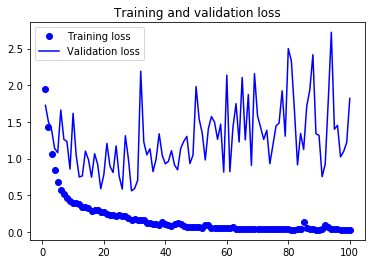

In [342]:
draw_evolution(history)

In [341]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 6s 6s/step - loss: 0.9634 - accuracy: 0.7400


[0.9634169936180115, 0.74]

In [343]:
name_of_model = 'Model_5_1024_0001_l2001_ep100_shuffle_bch64_a83_b52_c70_d74'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_1024_0001_l2001_ep100_shuffle_bch64_a83_b52_c70_d74\assets


'./Models\\Model_5_1024_0001_l2001_ep100_shuffle_bch64_a83_b52_c70_d74'

In [338]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 6s 6s/step - loss: 1.1203 - accuracy: 0.6933


[1.1203422546386719, 0.6933333]

In [339]:
name_of_model = 'Model_5_1024_0001_l2001_ep60_shuffle_bch64_a85_b42_c68_d69'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_1024_0001_l2001_ep60_shuffle_bch64_a85_b42_c68_d69\assets


'./Models\\Model_5_1024_0001_l2001_ep60_shuffle_bch64_a85_b42_c68_d69'

Test: Accuracy mean/std - 0.5220394730567932/0.1865079402923584
Test: Loss mean/std - 1.0635256797075272/0.3434277151855929
Train: Accuracy mean/std - 0.8980218768119812/0.09005864709615707
Train: Loss mean/std - 0.37431211873625564/0.3667926499227678


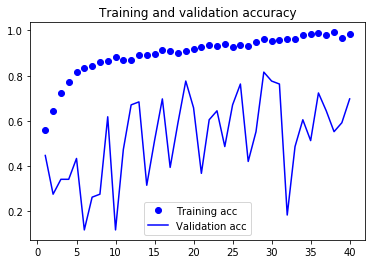

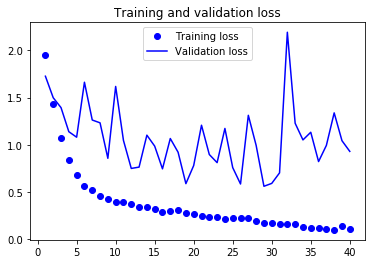

In [333]:
draw_evolution(history)

In [334]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)
model.evaluate(eval_gen4)

1/1 [==============================] - 6s 6s/step - loss: 0.5603 - accuracy: 0.8067


[0.5603086352348328, 0.8066667]

In [335]:
name_of_model = 'Model_5_1024_0001_l2001_ep20_shuffle_bch64_a83_b69_c78_d80'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_1024_0001_l2001_ep20_shuffle_bch64_a83_b69_c78_d80\assets


'./Models\\Model_5_1024_0001_l2001_ep20_shuffle_bch64_a83_b69_c78_d80'

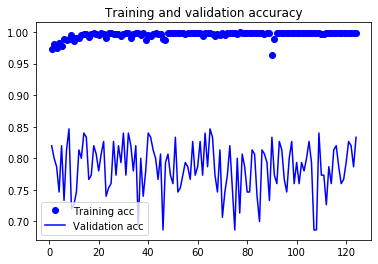

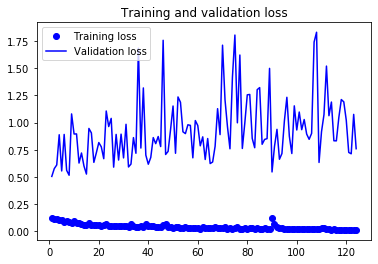

In [314]:
draw_evolution(history)

In [310]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)

1/1 [==============================] - 3s 3s/step - loss: 0.8611 - accuracy: 0.8077


[0.8610624074935913, 0.8076923]

In [313]:
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)

1/1 [==============================] - 16s 16s/step - loss: 0.8715 - accuracy: 0.7933


[0.8714727163314819, 0.79333335]

In [315]:
name_of_model = 'Model_5_512_0001_l2001_ep124_shuffle_bch64_a82_b77_c79'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l2001_ep124_shuffle_bch64_a82_b77_c79\assets


'./Models\\Model_5_512_0001_l2001_ep124_shuffle_bch64_a82_b77_c79'

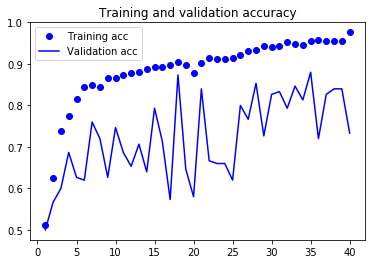

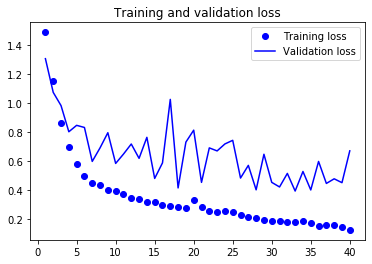

In [308]:
draw_evolution(history)

In [306]:
model.evaluate(eval_gen1)
model.evaluate(eval_gen2)
model.evaluate(eval_gen3)

1/1 [==============================] - 4s 4s/step - loss: 0.6405 - accuracy: 0.7436


[0.6404839158058167, 0.74358976]

In [307]:
name_of_model = 'Model_5_512_0001_l2001_ep40_shuffle_bch64_a85_b53_c74'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l2001_ep40_shuffle_bch64_a85_b53_c74\assets


'./Models\\Model_5_512_0001_l2001_ep40_shuffle_bch64_a85_b53_c74'

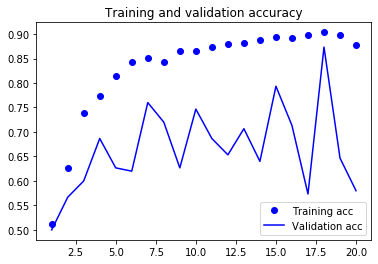

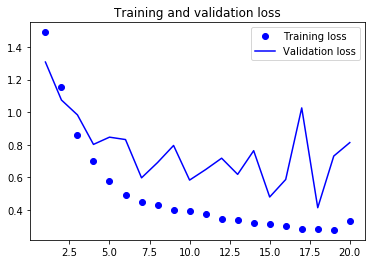

In [301]:
draw_evolution(history)

In [299]:
model.evaluate(eval_gen)

1/1 [==============================] - 16s 16s/step - loss: 0.4082 - accuracy: 0.8289


[0.4082433879375458, 0.82887703]

In [300]:
name_of_model = 'Model_5_512_0001_l2001_ep120_shuffle_bch64_acc82_eval'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l2001_ep120_shuffle_bch64_acc82_eval\assets


'./Models\\Model_5_512_0001_l2001_ep120_shuffle_bch64_acc82_eval'

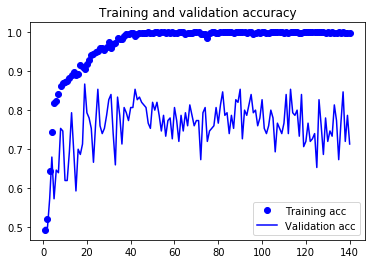

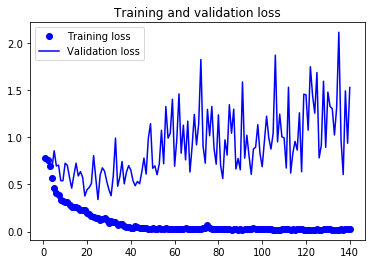

In [290]:
draw_evolution(history)

In [289]:
model.evaluate(eval_gen)

3/3 [==============================] - 6s 2s/step - loss: 1.1653 - accuracy: 0.7133


[1.1653262476126354, 0.7133333]

In [291]:
name_of_model = 'Model_5_512_0001_l20001_ep140_shuffle_bch64_acc71'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l20001_ep140_shuffle_bch64_acc71\assets


'./Models\\Model_5_512_0001_l20001_ep140_shuffle_bch64_acc71'

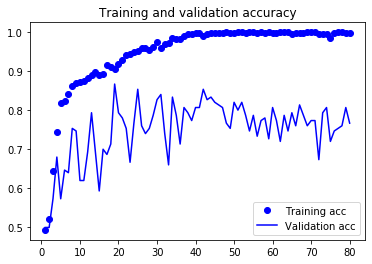

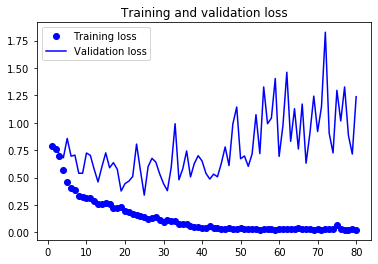

In [287]:
draw_evolution(history)

In [285]:
model.evaluate(eval_gen)

3/3 [==============================] - 6s 2s/step - loss: 1.0238 - accuracy: 0.7667


[1.0237860282262166, 0.76666665]

In [286]:
name_of_model = 'Model_5_512_0001_l20001_ep80_shuffle_bch64_acc76'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l20001_ep80_shuffle_bch64_acc76\assets


'./Models\\Model_5_512_0001_l20001_ep80_shuffle_bch64_acc76'

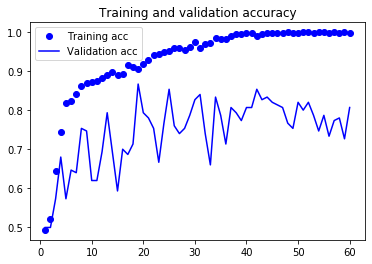

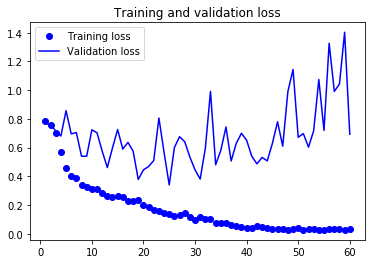

In [283]:
draw_evolution(history)

In [281]:
model.evaluate(eval_gen)

3/3 [==============================] - 7s 2s/step - loss: 0.6171 - accuracy: 0.8067


[0.6170507669448853, 0.8066667]

In [282]:
name_of_model = 'Model_5_512_0001_l20001_ep60_shuffle_bch64_acc80'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l20001_ep60_shuffle_bch64_acc80\assets


'./Models\\Model_5_512_0001_l20001_ep60_shuffle_bch64_acc80'

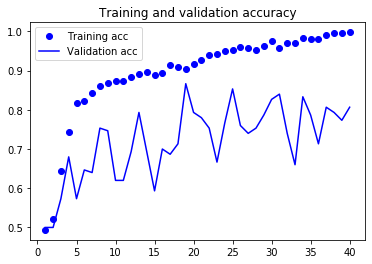

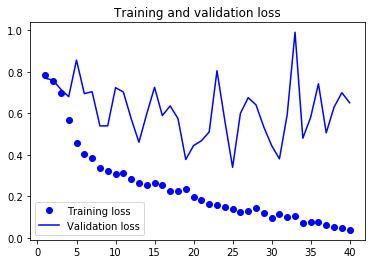

In [279]:
draw_evolution(history)

In [276]:
model.evaluate(eval_gen)

3/3 [==============================] - 6s 2s/step - loss: 0.5712 - accuracy: 0.8067


[0.5712093114852905, 0.8066667]

In [277]:
name_of_model = 'Model_5_512_0001_l20001_ep40_shuffle_bch64_acc80'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l20001_ep40_shuffle_bch64_acc80\assets


'./Models\\Model_5_512_0001_l20001_ep40_shuffle_bch64_acc80'

In [272]:
model.evaluate(eval_gen)

3/3 [==============================] - 7s 2s/step - loss: 0.4233 - accuracy: 0.7933


[0.423296978076299, 0.79333335]

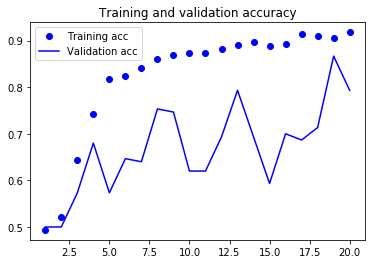

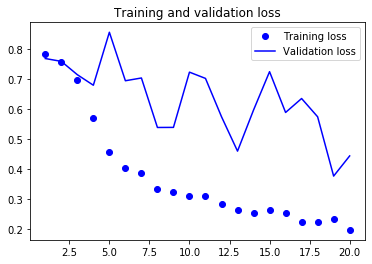

In [273]:
draw_evolution(history)

In [274]:
name_of_model = 'Model_5_512_0001_l20001_ep20_shuffle_bch64_acc79'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_l20001_ep20_shuffle_bch64_acc79\assets


'./Models\\Model_5_512_0001_l20001_ep20_shuffle_bch64_acc79'

In [266]:
model.evaluate(eval_gen)

3/3 [==============================] - 6s 2s/step - loss: 1.0644 - accuracy: 0.7400


[1.0643738905588787, 0.74]

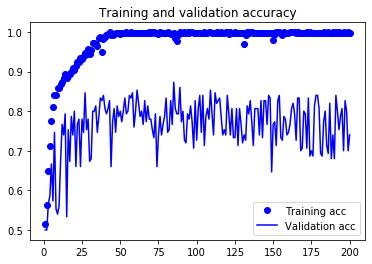

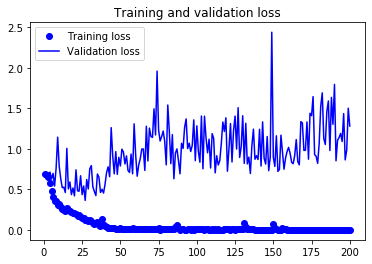

In [267]:
draw_evolution(history)

In [268]:
name_of_model = 'Model_5_512_0001_ep200_shuffle_bch64_acc74'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_512_0001_ep200_shuffle_bch64_acc74\assets


'./Models\\Model_5_512_0001_ep200_shuffle_bch64_acc74'

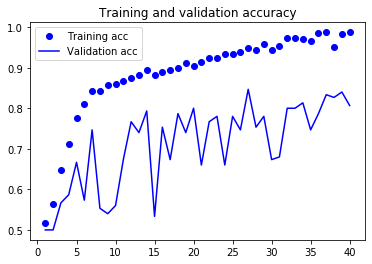

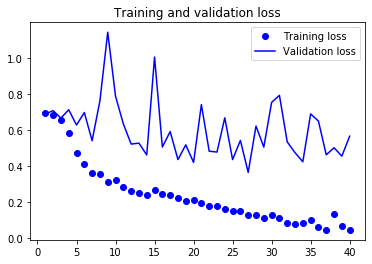

In [264]:
draw_evolution(history)

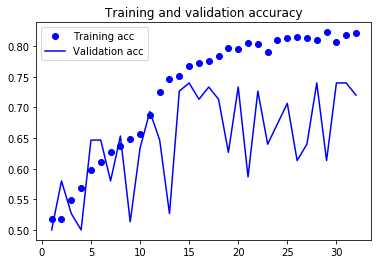

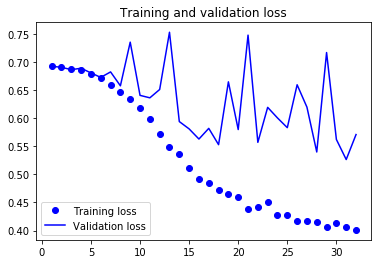

In [258]:
draw_evolution(history)

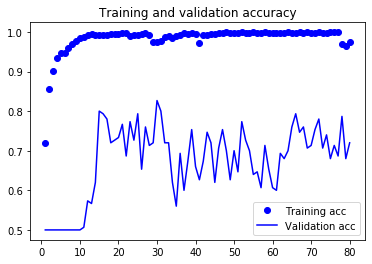

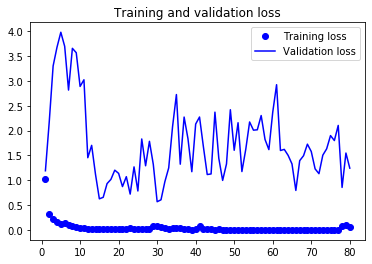

In [255]:
draw_evolution(history)

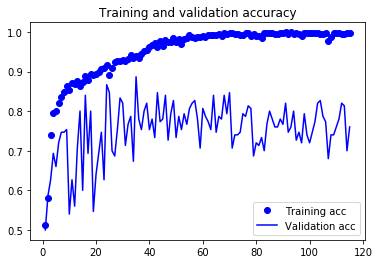

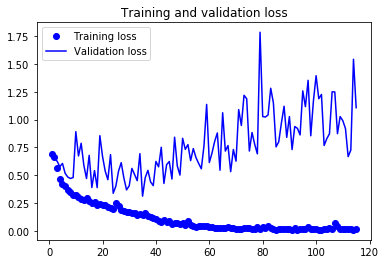

In [252]:
draw_evolution(history)

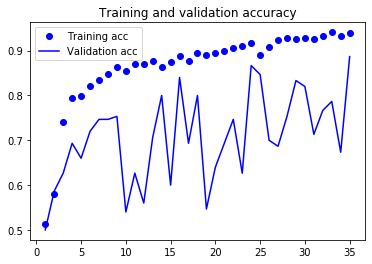

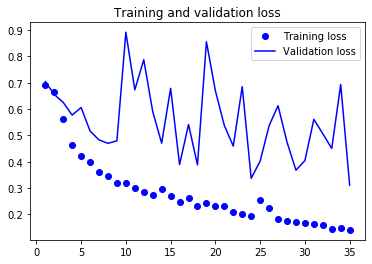

In [249]:
draw_evolution(history)

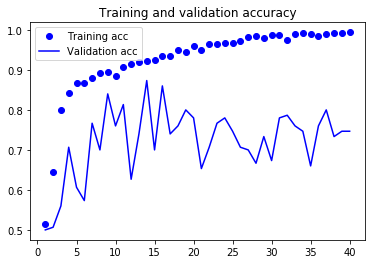

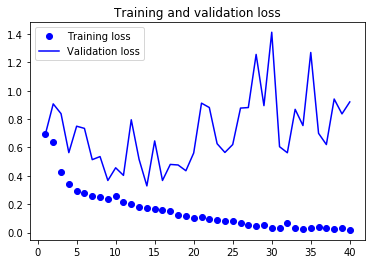

In [243]:
draw_evolution(history)

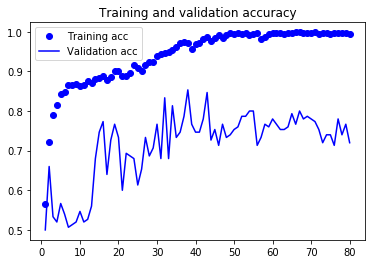

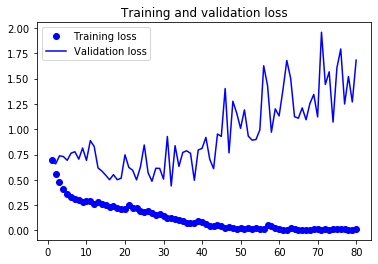

In [250]:
model.evaluate(eval_gen)

3/3 [==============================] - 6s 2s/step - loss: 0.4134 - accuracy: 0.7933


[0.41340405742327374, 0.79333335]

In [240]:
name_of_model = 'Model_5_dr05_512_00064_ep80_shuffle_bch64_acc72'
SaveModel(model,name_of_model)

INFO:tensorflow:Assets written to: ./Models\Model_5_dr05_512_00064_ep80_shuffle_bch64_acc72\assets


'./Models\\Model_5_dr05_512_00064_ep80_shuffle_bch64_acc72'

In [ ]:
name_of_model = 'Model_5_dr05_512_0007_ep80_bch128_acc84'


In [223]:
eval_gen = GetGenerator(test_df,TEST_DIR,bs = 1)

Found 150 validated image filenames belonging to 2 classes.


In [224]:
for i in range(140):
    img = iter(eval_gen).next()

In [225]:
img[1]

array([1.], dtype=float32)

In [199]:
img = img[0][0,:,:,:]

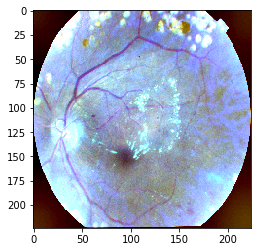

In [228]:
plt.imshow(img[0][0])

In [229]:
layer_outputs = [layer.output for layer in model.layers[:10]]
activation_model = tf.keras.models.Model(inputs = model.input, outputs=layer_outputs)

In [230]:
activations = activation_model.predict(img[0])

In [231]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 222, 222, 32)


(1, 5, 5, 512)


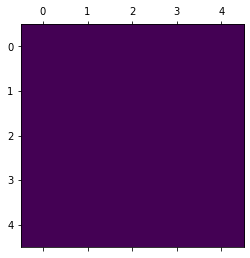

In [232]:
first_layer_activation = activations[9]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0,:,:,0],cmap = 'viridis')

C:\Users\PLDD\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


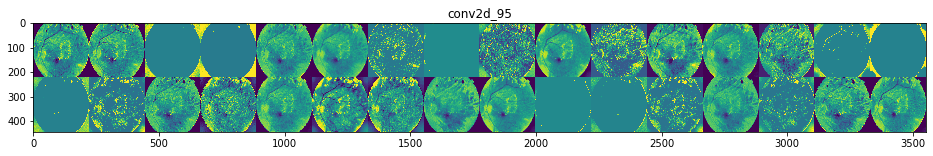

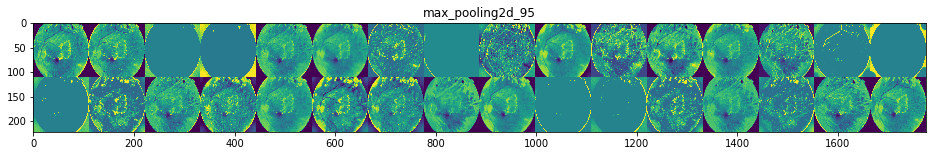

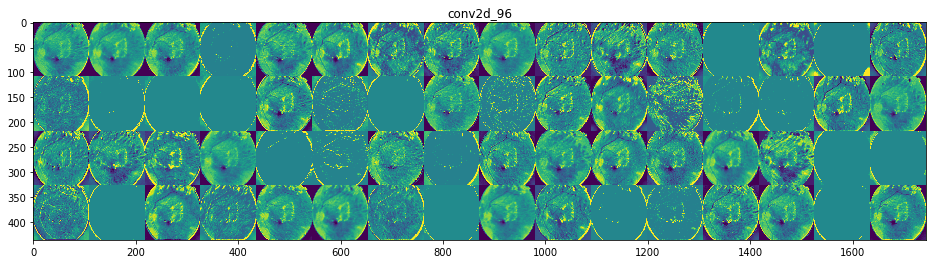

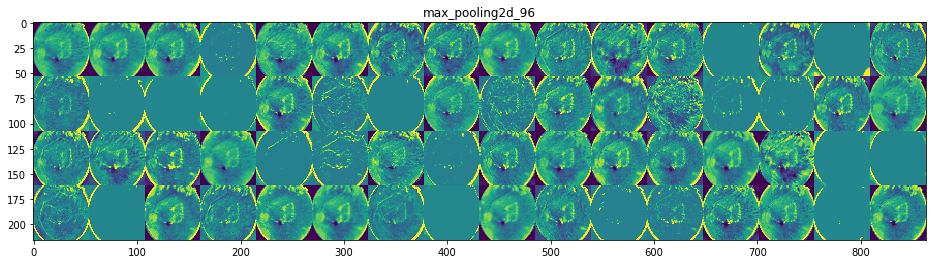

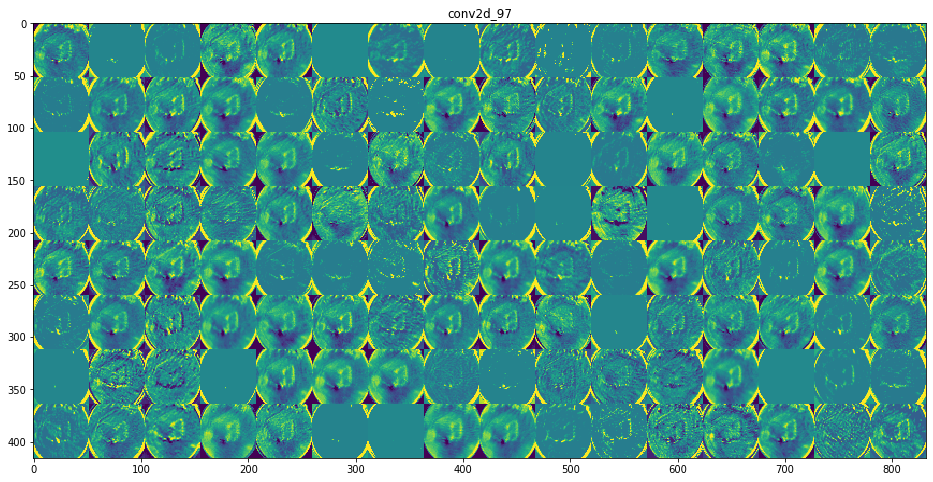

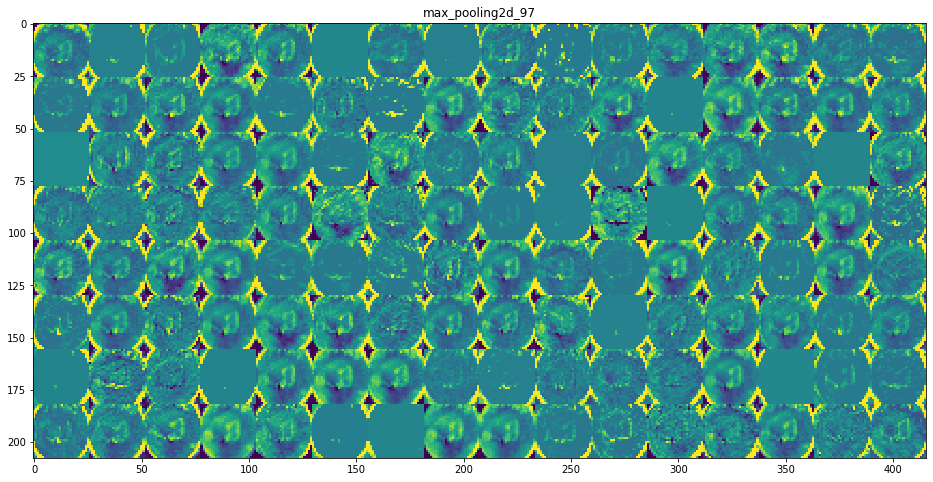

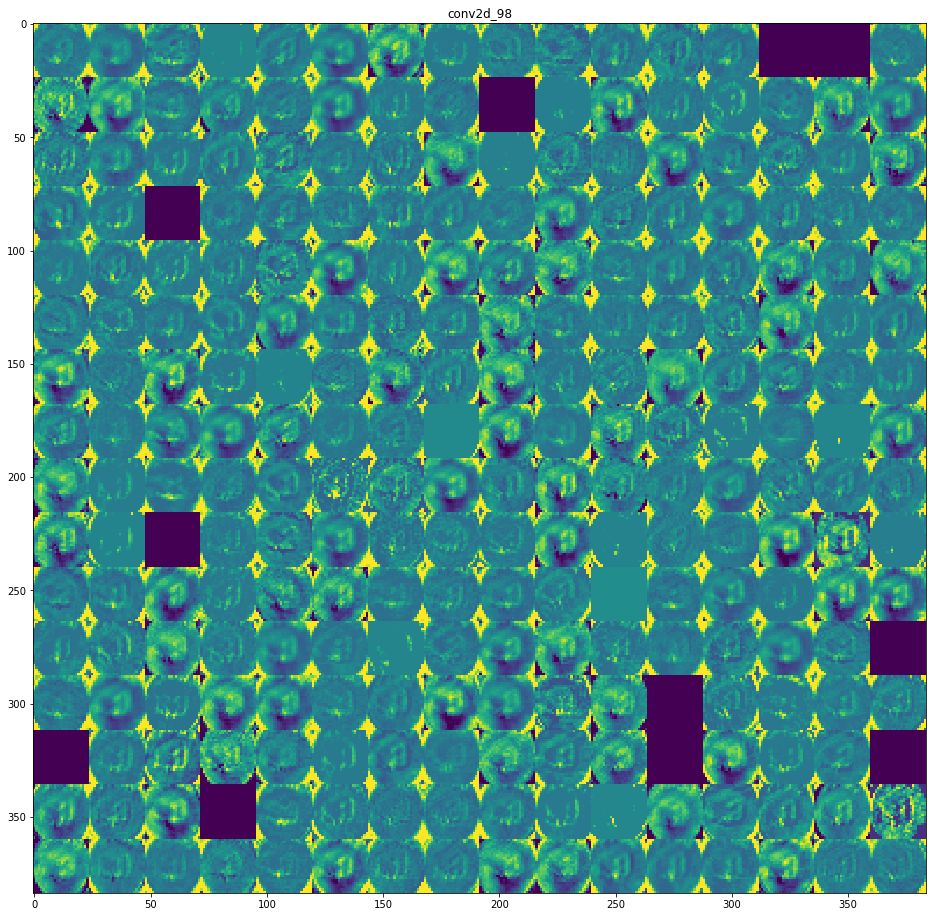

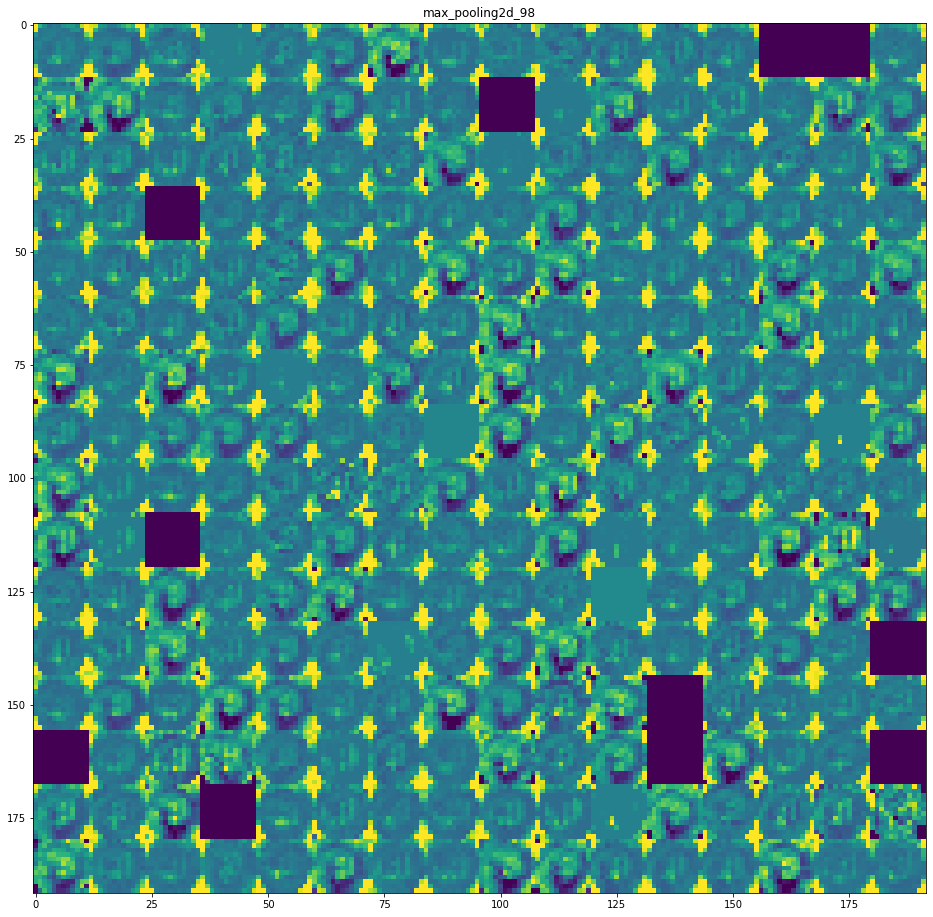

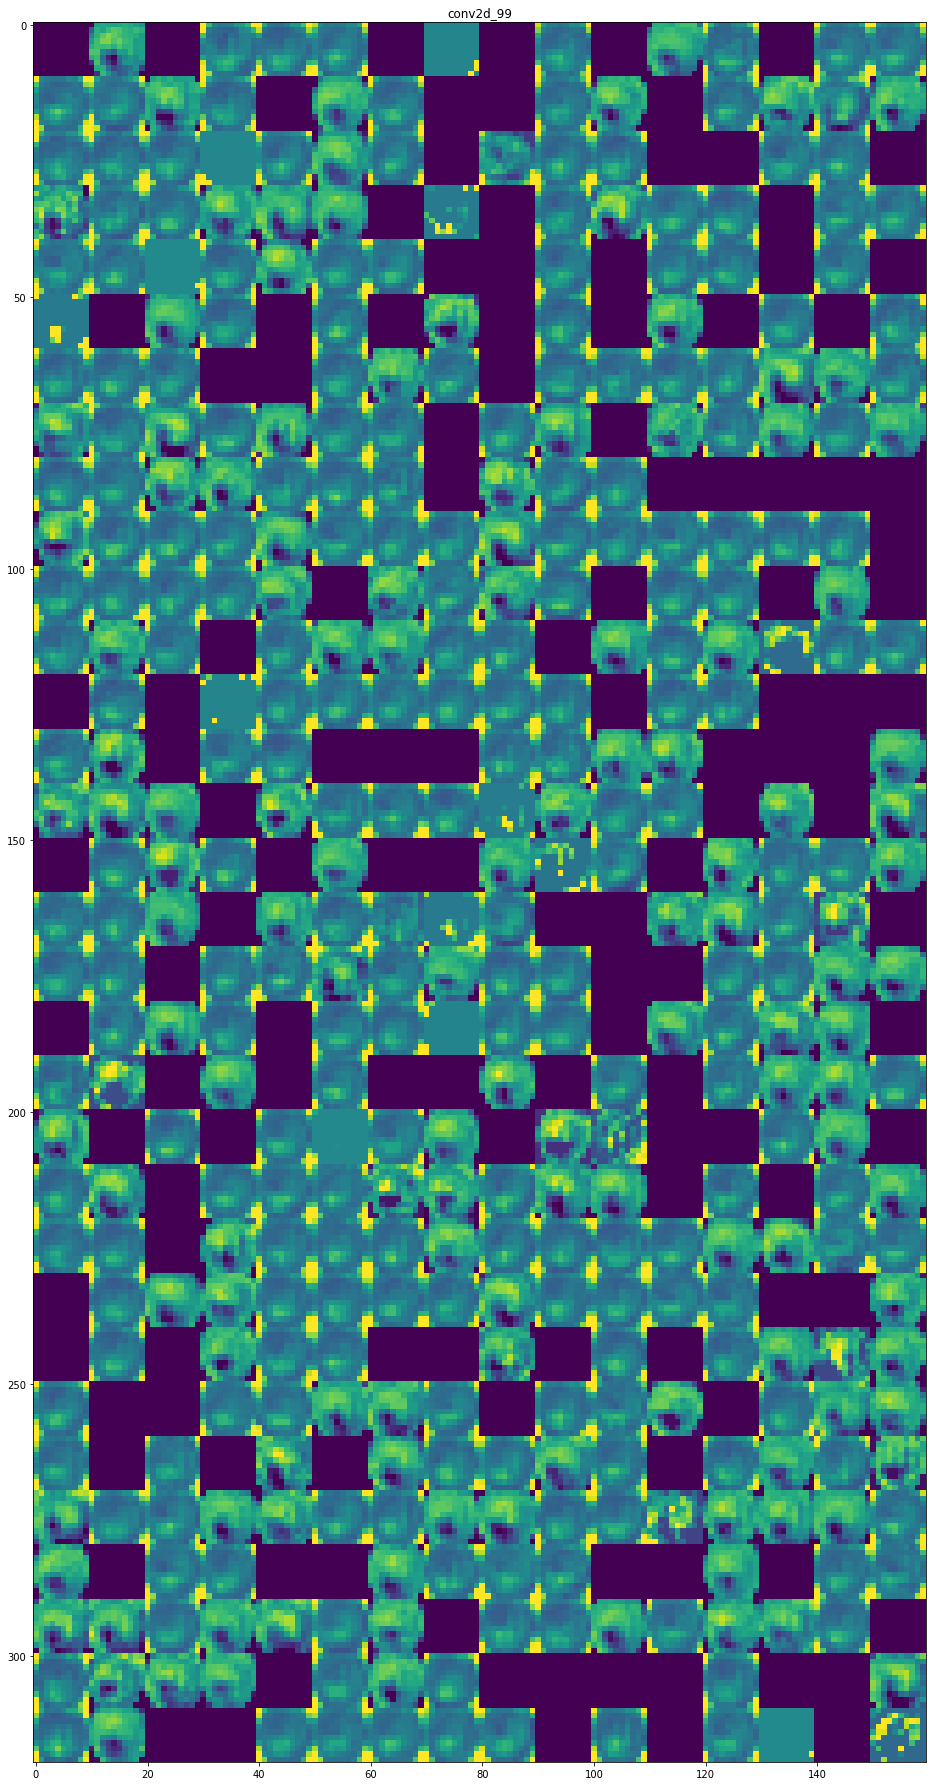

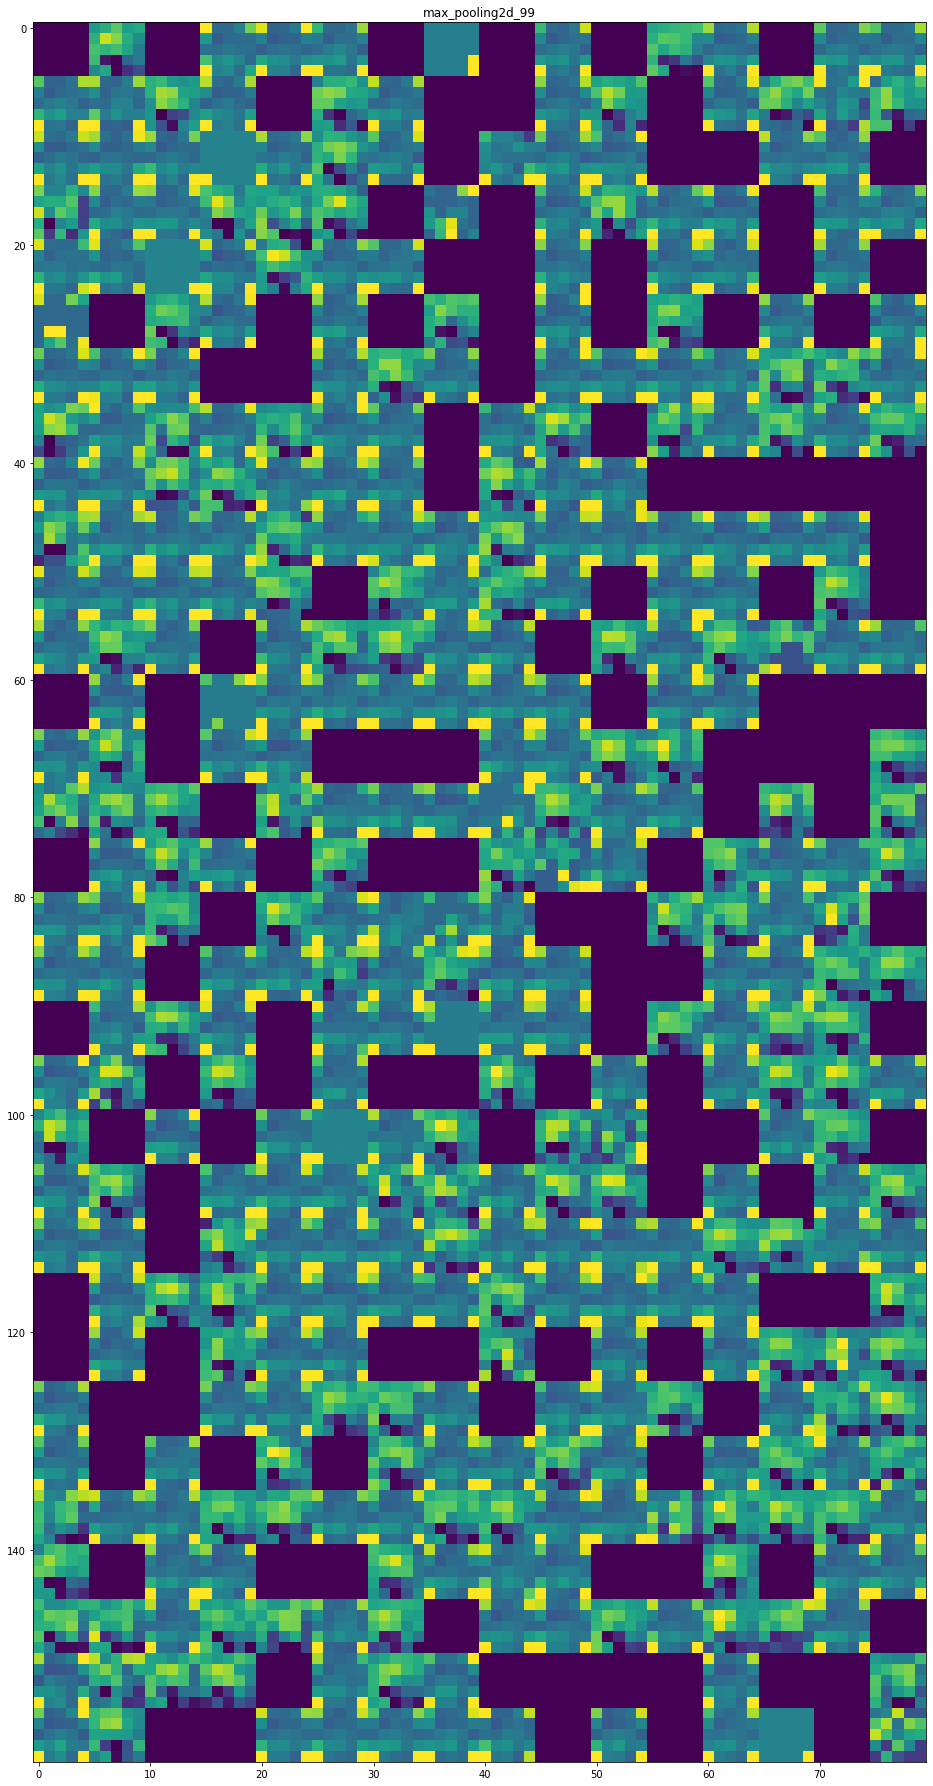

In [233]:
layer_names = []
for layer in model.layers[:10]:
    layer_names.append(layer.name)
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1)*size] = channel_image
    scale = 1./size
    plt.figure(figsize = (scale*display_grid.shape[1],
                         scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap = 'viridis')

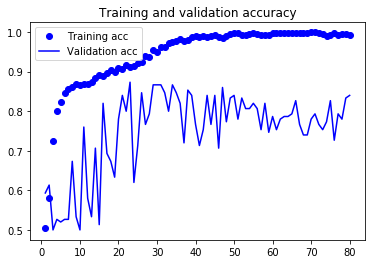

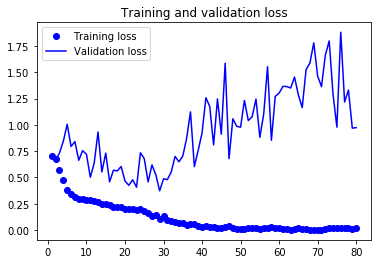

In [117]:
draw_evolution(history)

3/3 [==============================] - 8s 3s/step - loss: 0.7538 - accuracy: 0.8400


[0.7537725369135538, 0.84]

INFO:tensorflow:Assets written to: ./Models\Model_5_dr05_512_0007_ep80_bch128_acc84\assets


'./Models\\Model_5_dr05_512_0007_ep80_bch128_acc84'